In [ ]:
#what can be changed going down: workingDir, workingDir1 (or it can all be in 1 workingDir), ID, k, n
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import datetime as dt
import os
import sys
from functools import reduce

In [31]:
#Set user input variables
#Required directory structure
#  input data directory = workingDir/input/load_smoothing_algorithm/
#  output data directory = workingDir/output/load_smoothing_algorithm/
workingDir = os.path.dirname('/media/spin/projects/DR-LBNL/GE-ARPAE/GE-SCE-Collab/') #set your working directory
k = 11 #number of smoothing iteration
n = 5 #number of 15-min intervals around the peak (plus the peak) to which the shaved kW is re-distributed
DA_Customer = 0 #Used for calculating bill. 0 = non-direct access customer, 1 = direct access customer

In [27]:
#define functions
def monthlyOnPeakMaxDemand(df):
    # filtering out summer on-peak periods
    dfSummerOnPeakDemand = df[df['Rate Periods'] == 1] #$20.01/KW   
    # calculating maximum on-peak demand for each month
    mthOPD_Summer = dfSummerOnPeakDemand.groupby(["month"]).apply(lambda x: x.sort_values(["Base Usage kWh"], ascending = False)) #sort values
    mthOPD_Summer = mthOPD_Summer.reset_index(level=1).groupby('month').first() #choose the highest value each month
    # calculating max on-peak demand charge
    mthOPD_Summer ['On-Peak Demand (kW)'] = mthOPD_Summer['Base Usage kWh'] * 4 #kwh to kw 
    mthOPD_Summer['On-Peak Demand Charges ($)'] = mthOPD_Summer['Charges ($/kW)'] * mthOPD_Summer ['On-Peak Demand (kW)'] 
    mthOPD_Summer['On-Peak Demand Charges ($)'] = mthOPD_Summer['On-Peak Demand Charges ($)'].round(2)
    mthOPD_Summer = mthOPD_Summer.rename(columns={'Base Usage kWh':'On-Peak Energy (kWh)'})
    del mthOPD_Summer['Charges ($/kW)']
    return mthOPD_Summer

def monthlyMidPeakMaxDemand(df):
    # filtering out Summer and Winter mid-peak periods
    dfSummerMidPeakDemand = df[df['Rate Periods'] == 2] #$3.95/KW
    dfWinterMidPeakDemand = df[df['Rate Periods'] == 5] #$0.00/KW
    # calculating maximum on peak demand for each month
    mthMidD_Summer = dfSummerMidPeakDemand.groupby(["month"]).apply(lambda x: x.sort_values(["Base Usage kWh"], ascending = False)) #sort values
    mthMidD_Summer = mthMidD_Summer.reset_index(level=1).groupby('month').first() #choose the highest value each month
    mthMidD_Summer ['Mid-Peak Demand (kW)'] = mthMidD_Summer['Base Usage kWh'] *4 
    mthMidD_Summer['Mid-Peak Demand Charges ($)'] = mthMidD_Summer['Charges ($/kW)'] *  mthMidD_Summer ['Mid-Peak Demand (kW)']
    mthMidD_Winter = dfWinterMidPeakDemand.groupby(["month"]).apply(lambda x: x.sort_values(["Base Usage kWh"], ascending = False)) #sort values
    mthMidD_Winter = mthMidD_Winter.reset_index(level=1).groupby('month').first()
    mthMidD_Winter['Mid-Peak Demand (kW)'] = mthMidD_Winter['Base Usage kWh'] * 4
    mthMidD_Winter['Mid-Peak Demand Charges ($)'] = mthMidD_Winter['Charges ($/kW)'] * mthMidD_Winter['Mid-Peak Demand (kW)'] 
    # concatenate summer and winter off peak
    mthMidD = pd.concat([mthMidD_Summer, mthMidD_Winter])
    mthMidD['Mid-Peak Demand Charges ($)'] = mthMidD['Mid-Peak Demand Charges ($)'].round(2)
    mthMidD = mthMidD.rename(columns={'Base Usage kWh':'Mid-Peak Energy (kWh)'})
    del mthMidD['Charges ($/kW)']
    return mthMidD

def monthlyOffPeakMaxDemand(df): #it is $0.00 on off - peak demand bill for non-DA customer
    # filtering out Summer and Winter off-peak periods
    dfSummerOffPeakDemand = df[df['Rate Periods'] == 3] #$0.00/KW
    dfWinterOffPeakDemand = df[df['Rate Periods'] == 6] #$0.00/KW
    # calculating maximum on peak demand for each month
    mthOffD_Summer = dfSummerOffPeakDemand.groupby(["month"]).apply(lambda x: x.sort_values(["Base Usage kWh"], ascending = False)) #sort values
    mthOffD_Summer = mthOffD_Summer.reset_index(level=1).groupby('month').first() #choose the highest value each month
    mthOffD_Summer ['Off-Peak Demand (kW)'] = mthOffD_Summer['Base Usage kWh'] *4 
    mthOffD_Summer['Off-Peak Demand Charges ($)'] = mthOffD_Summer['Charges ($/kW)'] *  mthOffD_Summer ['Off-Peak Demand (kW)']
    mthOffD_Winter = dfWinterOffPeakDemand.groupby(["month"]).apply(lambda x: x.sort_values(["Base Usage kWh"], ascending = False)) #sort values
    mthOffD_Winter = mthOffD_Winter.reset_index(level=1).groupby('month').first()
    mthOffD_Winter['Off-Peak Demand (kW)'] = mthOffD_Winter['Base Usage kWh'] * 4
    mthOffD_Winter['Off-Peak Demand Charges ($)'] = mthOffD_Winter['Charges ($/kW)'] * mthOffD_Winter['Off-Peak Demand (kW)']
    # concatenate summer and winter off peak
    mthOffD = pd.concat([mthOffD_Summer, mthOffD_Winter])
    mthOffD['Off-Peak Demand Charges ($)'] = mthOffD['Off-Peak Demand Charges ($)'].round(2)
    mthOffD = mthOffD.rename(columns={'Base Usage kWh':'Off-Peak Energy (kWh)'})
    del mthOffD['Charges ($/kW)']
    return mthOffD

def DemandFacilityCharge(df):
    # define demand facility charge rate
    DemandFacilityCharge = 17.81    
    # calculate monthly demand
    mthFacilityDemand = df.groupby(["month"]).apply(lambda x: x.sort_values(["Base Usage kWh"], ascending = False)) #sort values
    mthFacilityDemand = mthFacilityDemand.reset_index(level=1).groupby('month').first() 
    mthFacilityDemand['Facility Demand (kW)'] = mthFacilityDemand['Base Usage kWh'] * 4
    mthFacilityDemand['Facility_Demand Charges ($)'] = DemandFacilityCharge * mthFacilityDemand['Facility Demand (kW)']   
    # rename the columns
    mthFacilityDemand['Facility_Demand Charges ($)'] = mthFacilityDemand['Facility_Demand Charges ($)'].round(2)
    return mthFacilityDemand

def monthlyOnPeakEnergy(df):
    # filtering out summer on-peak periods
    dfSummerEnergyOnPeak = df[df['Rate Periods'] == 1].copy()
    # calculating on-peak energy for each month
    dfSummerEnergyOnPeak['On-Peak Energy Charges ($)'] = dfSummerEnergyOnPeak['Energy_charges($/kWh)'] * dfSummerEnergyOnPeak['Base Usage kWh']
    mthOPE_Summer = dfSummerEnergyOnPeak.groupby(['CustomerID','month','Rate Periods'], as_index = False)['Base Usage kWh','On-Peak Energy Charges ($)'].sum()
    mthOPE_Summer['On-Peak Energy Charges ($)'] = mthOPE_Summer['On-Peak Energy Charges ($)'].round(2)
    mthOPE_Summer = mthOPE_Summer.groupby(['month','CustomerID'],as_index = False)['On-Peak Energy Charges ($)'].sum()
    return mthOPE_Summer

def monthlyOffPeakEnergy(df):
    # filtering out Summer off-peak periods
    dfSummerEnergyOffPeak = df[df['Rate Periods'] == 3].copy()
    # calculating Summer off-peak energy for each month
    dfSummerEnergyOffPeak['Off-Peak Energy Charges ($)'] = dfSummerEnergyOffPeak['Energy_charges($/kWh)'] * dfSummerEnergyOffPeak['Base Usage kWh']
    mthOffE_Summer = dfSummerEnergyOffPeak.groupby(['CustomerID','month','Rate Periods'], as_index = False)['Base Usage kWh','Off-Peak Energy Charges ($)'].sum()
    # filtering out winter off-peak periods
    dfWinterEnergyOffPeak = df[df['Rate Periods'] == 6].copy()
    # calculating Winter off-peak energy for each month
    dfWinterEnergyOffPeak['Off-Peak Energy Charges ($)'] = dfWinterEnergyOffPeak['Energy_charges($/kWh)'] * dfWinterEnergyOffPeak['Base Usage kWh']
    mthOffE_Winter = dfWinterEnergyOffPeak.groupby(['CustomerID','month','Rate Periods'], as_index = False)['Base Usage kWh','Off-Peak Energy Charges ($)'].sum()
    # concatenate Summer and Winter off-peak energy
    mthOffE = pd.concat([mthOffE_Summer, mthOffE_Winter])
    mthOffE['Off-Peak Energy Charges ($)'] = mthOffE['Off-Peak Energy Charges ($)'].round(2)
    #sort by Month, and rename the columns
    mthOffE = mthOffE.groupby(['month','CustomerID'],as_index = False)['Off-Peak Energy Charges ($)'].sum()
    return mthOffE

def monthlyMidPeakEnergy(df):
    # filtering out Summer Mid-peak periods
    dfSummerEnergyMidPeak = df[df['Rate Periods'] == 2].copy()
    # calculating Summer Mid-peak energy for each month
    dfSummerEnergyMidPeak['Mid-Peak Energy Charges ($)'] = dfSummerEnergyMidPeak['Energy_charges($/kWh)'] * dfSummerEnergyMidPeak['Base Usage kWh']
    mthMidE_Summer = dfSummerEnergyMidPeak.groupby(['CustomerID','month','Rate Periods'], as_index = False)['Base Usage kWh','Mid-Peak Energy Charges ($)'].sum()
    # filtering out Winter Mid-peak periods
    dfWinterEnergyMidPeak = df[df['Rate Periods'] == 5].copy()
    # calculating Winter Mid-peak energy for each month
    dfWinterEnergyMidPeak['Mid-Peak Energy Charges ($)'] = dfWinterEnergyMidPeak['Energy_charges($/kWh)'] * dfWinterEnergyMidPeak['Base Usage kWh']
    mthMidE_Winter = dfWinterEnergyMidPeak.groupby(['CustomerID','month','Rate Periods'], as_index = False)['Base Usage kWh','Mid-Peak Energy Charges ($)'].sum()
    # concatenate Summer and Winter Mid-peak energy
    mthMidE = pd.concat([mthMidE_Summer, mthMidE_Winter])
    mthMidE['Mid-Peak Energy Charges ($)'] = mthMidE['Mid-Peak Energy Charges ($)'].round(2)
    # sort by Month and rename the columns
    mthMidE = mthMidE.groupby(['month','CustomerID'],as_index = False)['Mid-Peak Energy Charges ($)'].sum()
    return mthMidE

def add_iteration_bill(df,a): #put iteration as the first column
    new_df = pd.DataFrame([df])
    new_df['Iteration']= '%d' % (a)
    cols = list(new_df)
    cols.insert(0, cols.pop(cols.index('Iteration')))
    new_df = new_df.ix[:, cols]
    return new_df


In [ ]:
# Read in input data located in workingDir/input/load-smoothing-algorithm/bill_calc
# energy charges
energy_charges_input = pd.read_csv(os.path.join(workingDir,'input/load-smoothing-algorithm/bill_calc/TOU_GS3_B_Energy.csv'))
# energy charges for DA customers
energy_charges_input_DA = pd.read_csv(os.path.join(workingDir,'input/load-smoothing-algorithm/bill_calc/TOU_GS3_B_Energy_DA.csv'))
# demand charges
demand_charges_input = pd.read_csv(os.path.join(workingDir,'input/load-smoothing-algorithm/bill_calc/TOU_GS3_B_Demand.csv'))
# demand charges for DA customers
demand_charges_input_DA = pd.read_csv(os.path.join(workingDir,'input/load-smoothing-algorithm/bill_calc/TOU_GS3_B_Demand_DA.csv'))
# UT hourly time periods
UT_hourly_time_periods_input = pd.read_csv(os.path.join(workingDir,'input/load-smoothing-algorithm/bill_calc/TOU_GS3_B_Seasonal_TimePeriods_daylightsaving_leapyear.csv'))
# change column names
energy_charges_input = energy_charges_input.rename(columns={'TOU-GS3-B':'Charges ($/kWh)','Number':'Rate Periods'})
demand_charges_input = demand_charges_input.rename(columns={'TOU-GS3-B':'Charges ($/kW)','Number':'Rate Periods'})
UT_hourly_time_periods_input = UT_hourly_time_periods_input.rename(columns={'TOU-GS3-B':'Rate Periods'})

# if DA customers = 1, 0 for non-DA customers
if DA_Customer == 0:
    demand_charges = demand_charges_input
    energy_charges = energy_charges_input
    DA_CRS_DWR_bond = 0
else:
    demand_charges = demand_charges_input_DA
    energy_charges = energy_charges_input_DA
    DA_CRS_DWR_bond = 0.00549

#normalizing orginal data
SCEformat = pd.read_csv(os.path.join(workingDir, 'input/load-smoothing-algorithm/SCE-format-data.csv')) #read in csv file from EnerNoc data
del SCEformat['Unnamed: 0']
SCEformat['DateTime'] = pd.to_datetime(SCEformat['DateTime']) #change datatypes to datetime.
SCEformat['month']=SCEformat.DateTime.map(lambda x: x.strftime('%m'))
norm_k = lambda x: x/x.mean()
SCEformat['Norm']= SCEformat.groupby(['CustomerID', 'month']).transform(norm_k) #normalize by month
SCEformat.to_csv(os.path.join(workingDir, 'input/load-smoothing-algorithm/Normalized-data.csv'))

#Create and add time columns to customer consumption data, tweak time
consumption_raw_data_input = pd.read_csv(os.path.join(workingDir, 'input/load-smoothing-algorithm/Normalized-data.csv')) #use SCE format data.csv if do not care about normalization
consumption_raw_data_input = consumption_raw_data_input.rename(columns={'Usage_KWH':'Base Usage kWh'})
del consumption_raw_data_input['Unnamed: 0']
consumption_raw_data_input['DateTime']=pd.to_datetime(consumption_raw_data_input['DateTime'])
consumption_raw_data_input.index = consumption_raw_data_input['DateTime']
day = consumption_raw_data_input['DateTime'].dt.day
hour = consumption_raw_data_input['DateTime'].dt.hour
minute = consumption_raw_data_input['DateTime'].dt.minute
day_of_year = consumption_raw_data_input['DateTime'].dt.dayofyear
year = consumption_raw_data_input['DateTime'].dt.year
del consumption_raw_data_input['DateTime']
consumption_data_input = pd.concat([day, hour, minute, day_of_year, year, consumption_raw_data_input], axis=1)
consumption_data_input.columns = ['day', 'hour', 'minute', 'day_of_year', 'year', 'Base Usage kWh','CustomerID','month','Norm']
consumption_data_input.replace(2013,2012,inplace=True)

#demand charges
UTdemandCharges = pd.merge(UT_hourly_time_periods_input, demand_charges, how='left', on=['Rate Periods'])
UTdemandCharges = UTdemandCharges[UTdemandCharges.index % 4 == 0] #only keep one column out of 4 repeated column for the hour
UTdemandCharges.reset_index(inplace=True,drop=True)

#Merge customer consumption data with demand charges and energy charges, and output to .csv
UTdemandConsumption = pd.merge(consumption_data_input, UTdemandCharges, how='left', on=['month','day','hour'])
UTdemandConsumption = UTdemandConsumption.drop_duplicates(subset=['month','day','hour','minute','Norm','CustomerID']) #there are some duplicates in November 4th daylight savings at 2am so drop them
UTdemandConsumption.to_csv(os.path.join(workingDir, 'output/load-smoothing-algorithm/UTdemandConsumption.csv'))
UTConsumption = pd.merge(UTdemandConsumption,energy_charges, how='left', on=['Rate Periods','Season','Hour'])
UTConsumption = UTConsumption.rename(columns ={'Charges ($/kWh)': 'Energy_charges($/kWh)'})
UTConsumption.to_csv(os.path.join(workingDir, 'output/load-smoothing-algorithm/UTconsumption.csv')) #big file with all data for load smoothing

/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: 'month' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


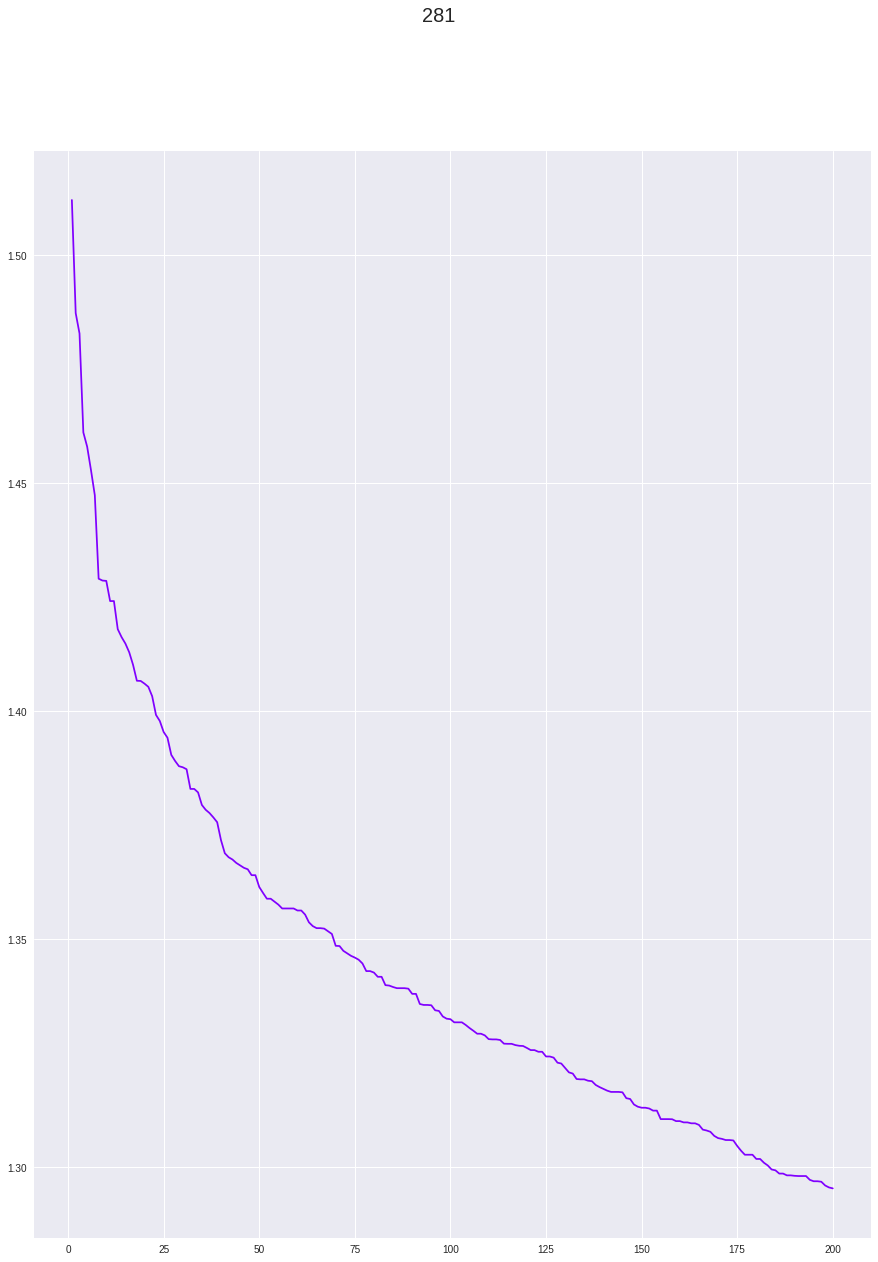

/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'month' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: 'month' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: 'month' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: 'month' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 'month' is bo

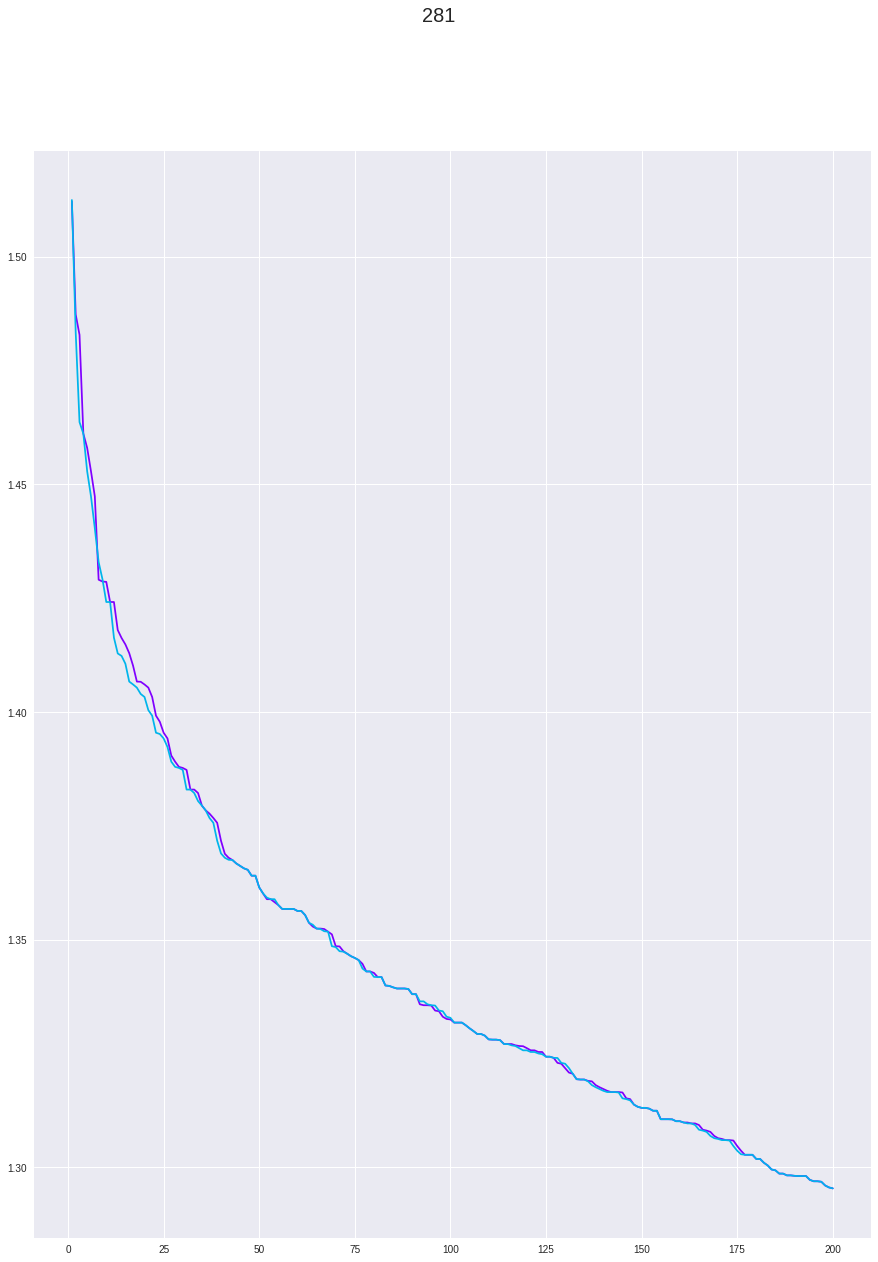

10


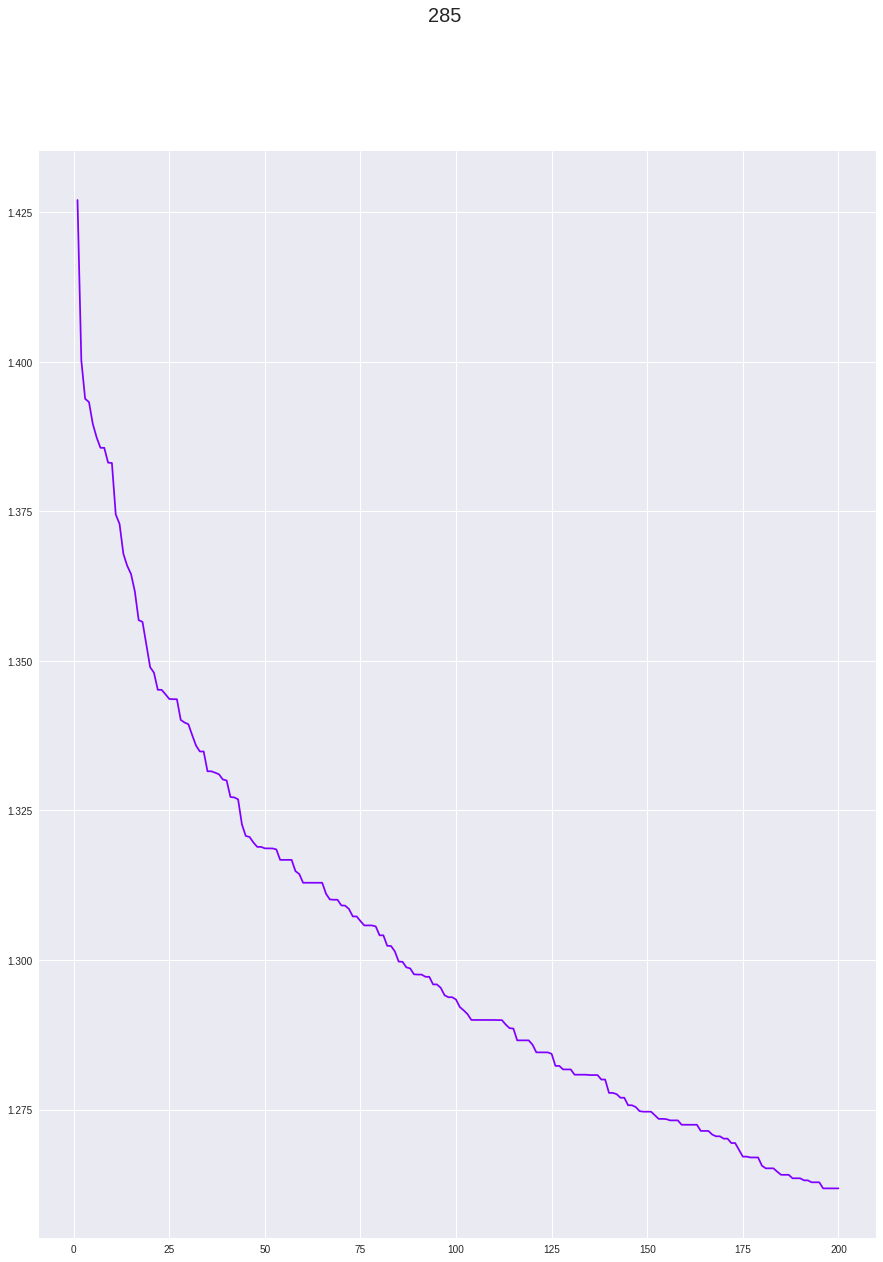

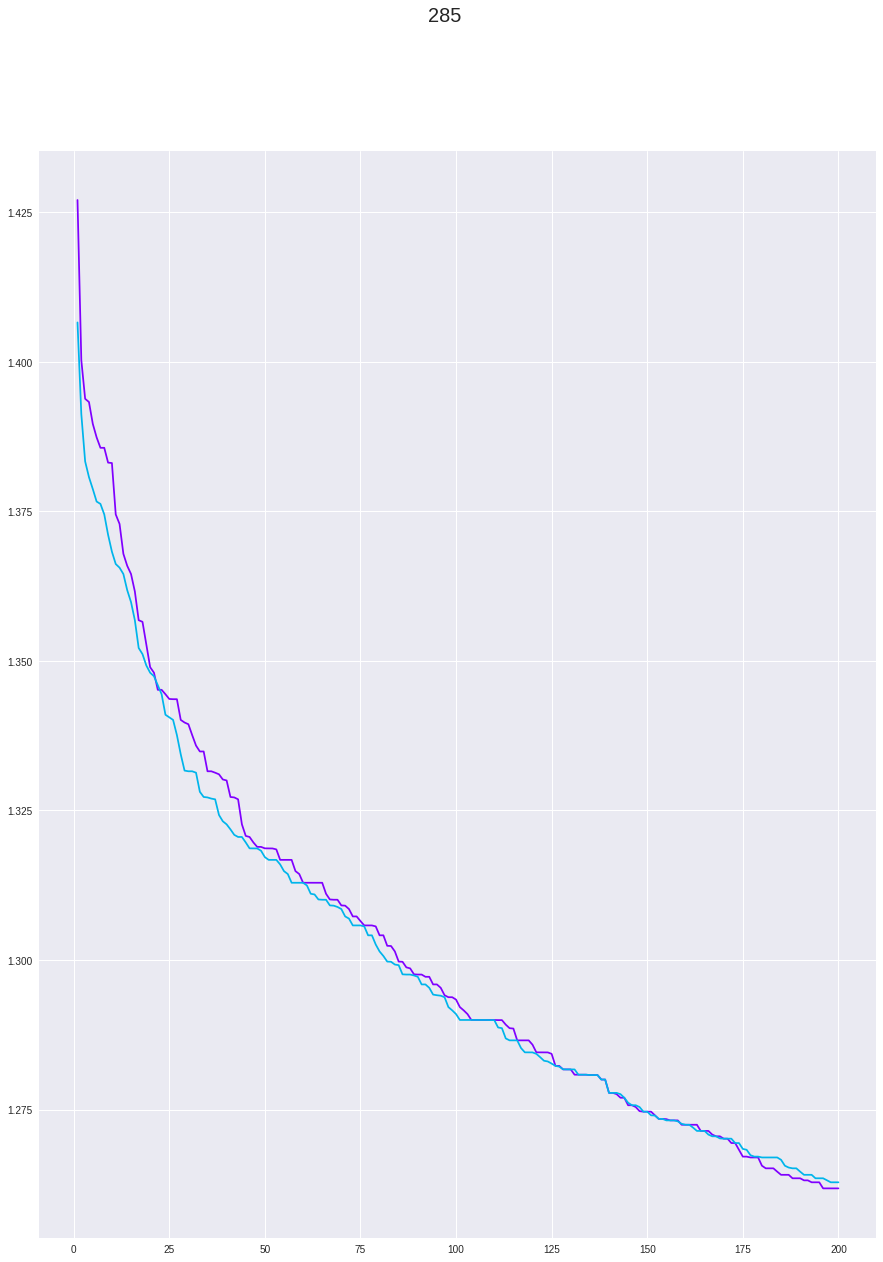

10


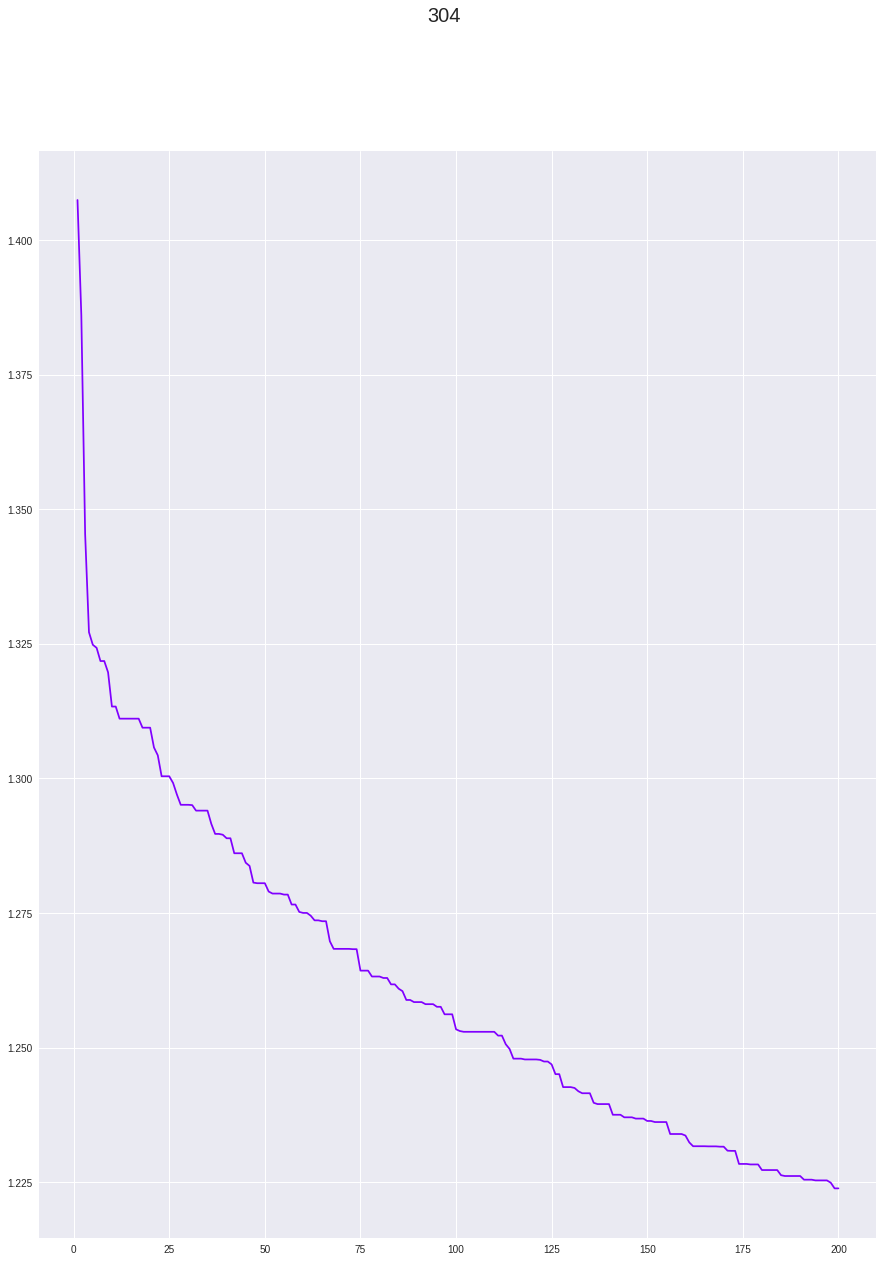

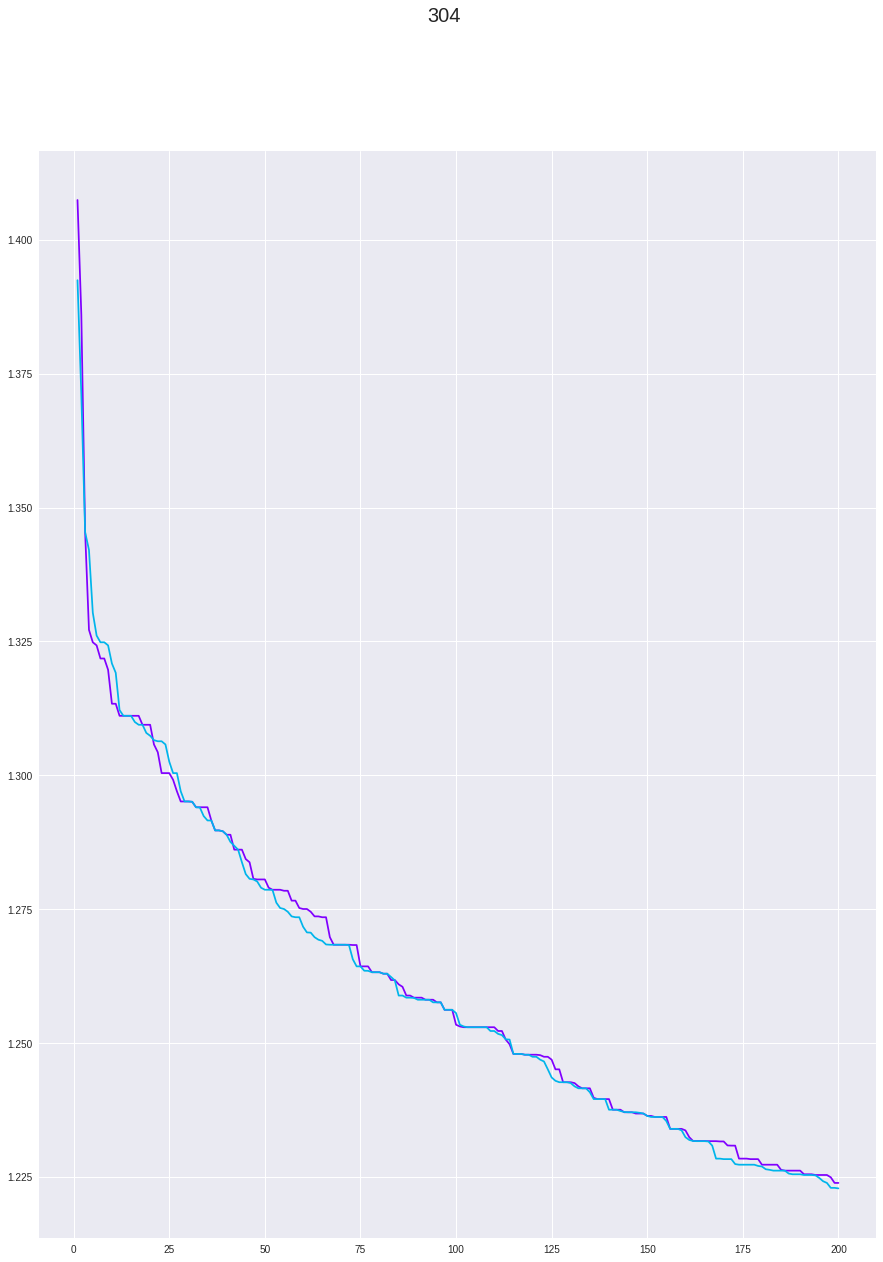

10


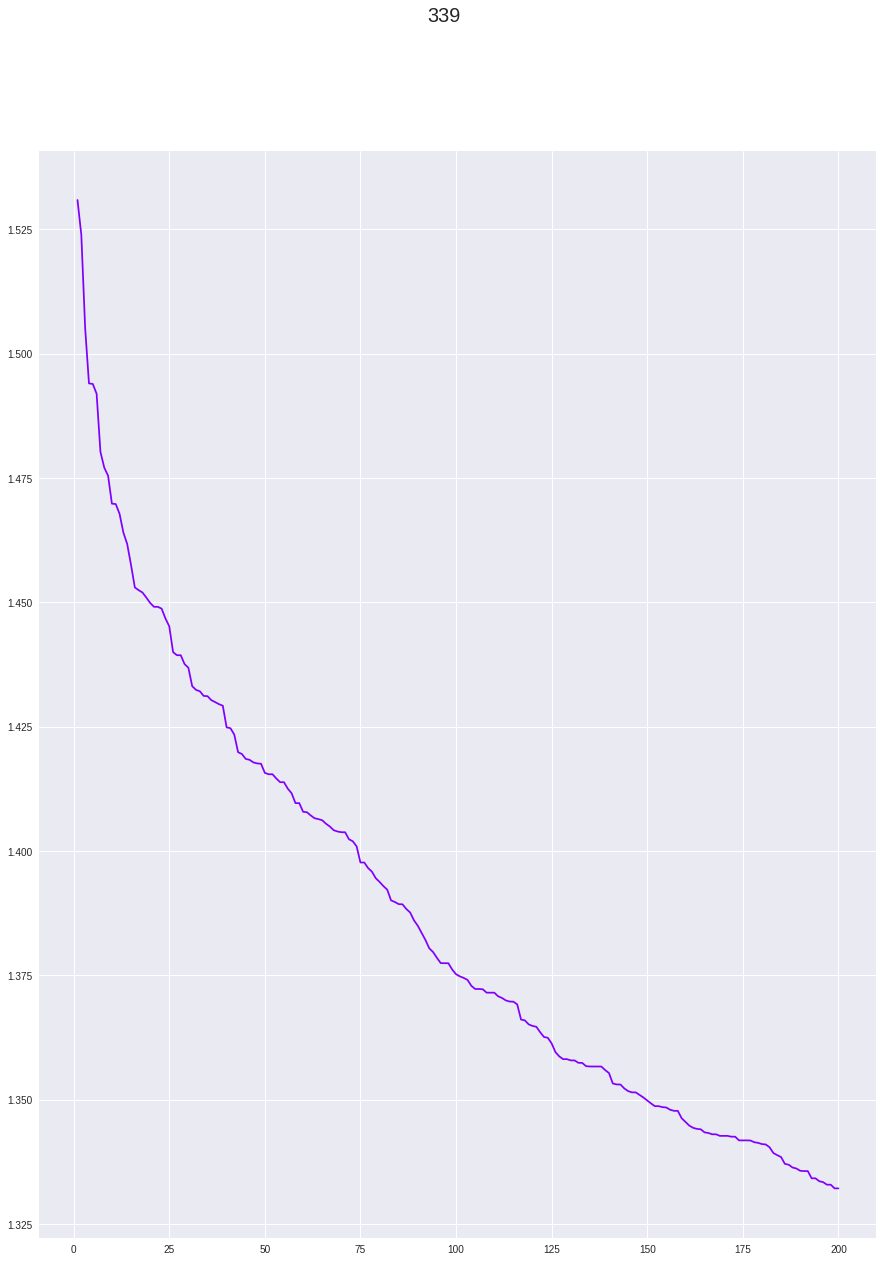

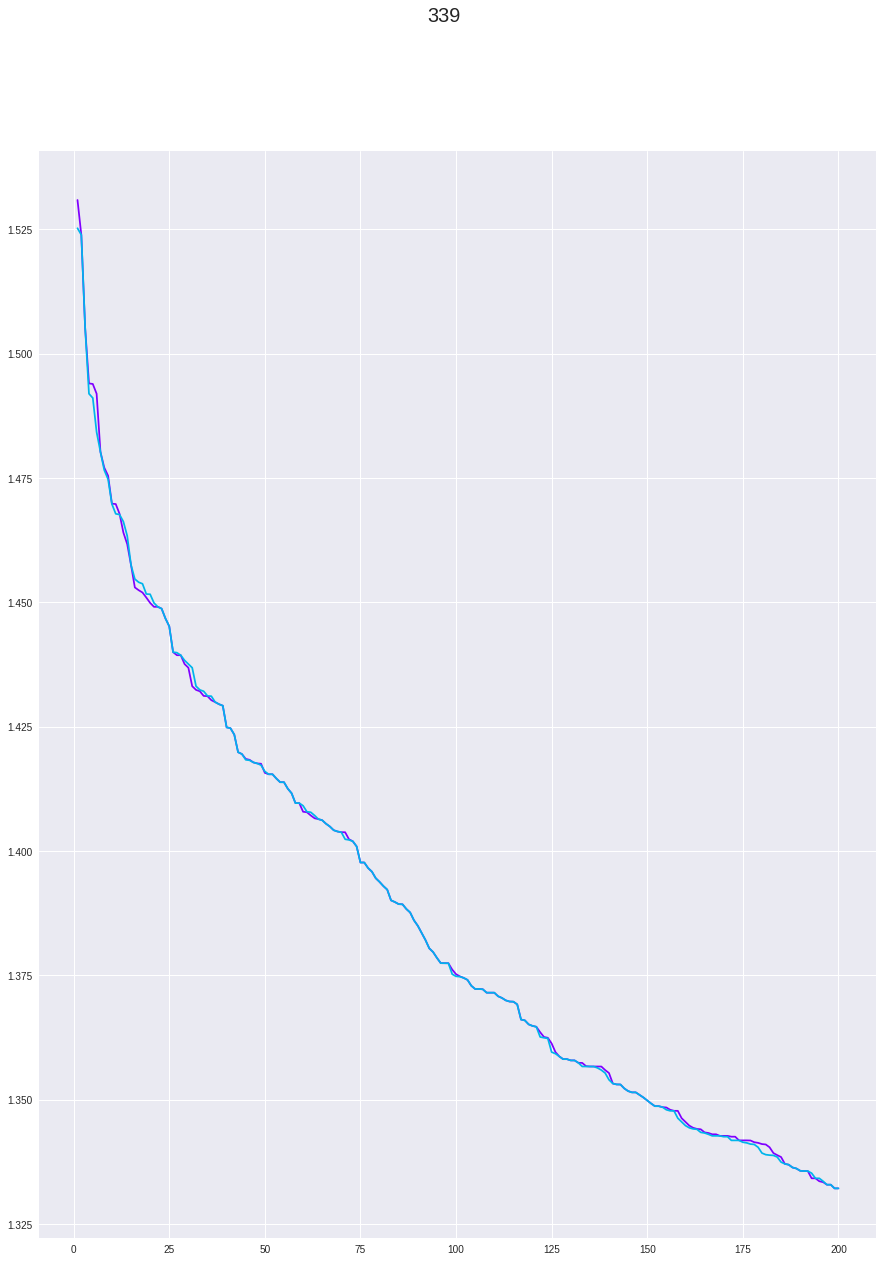

10


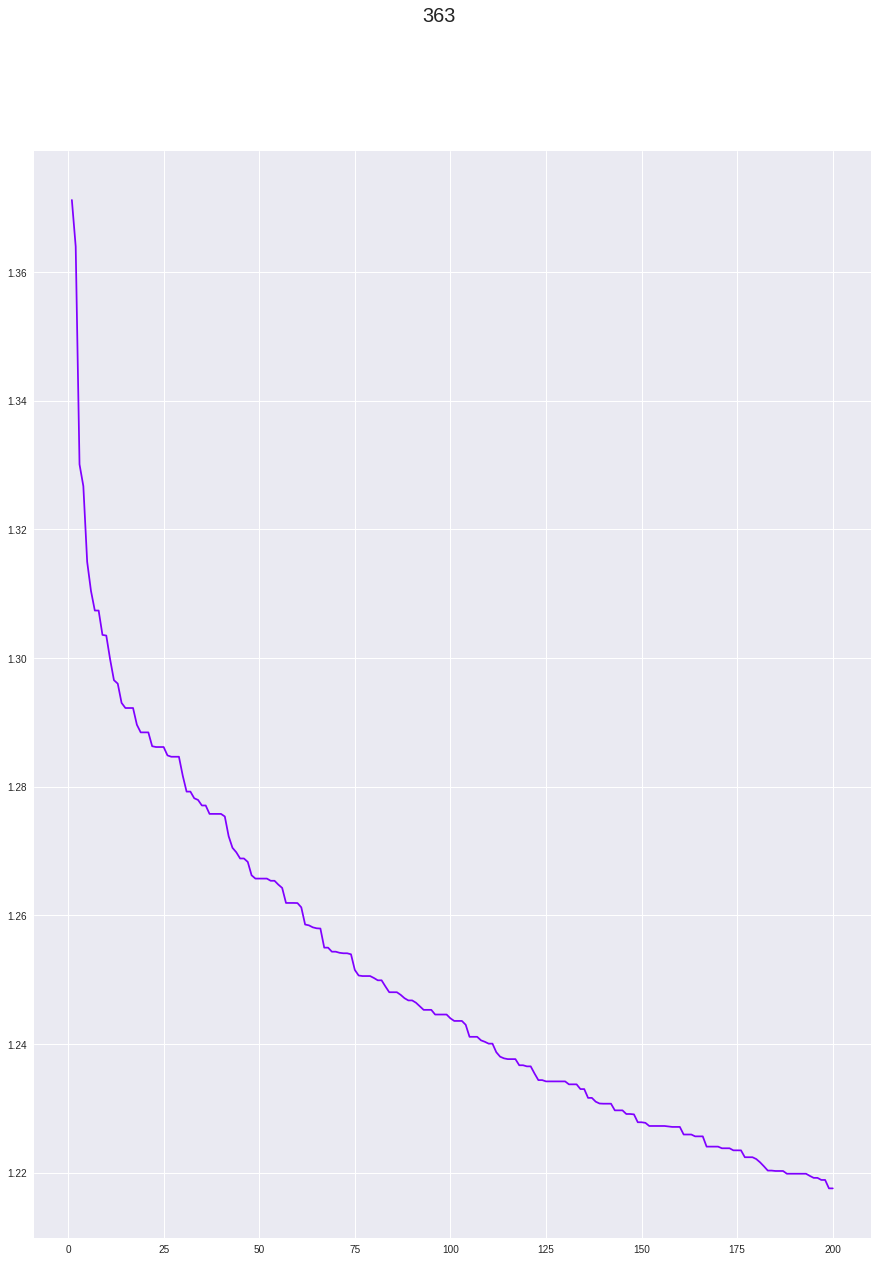

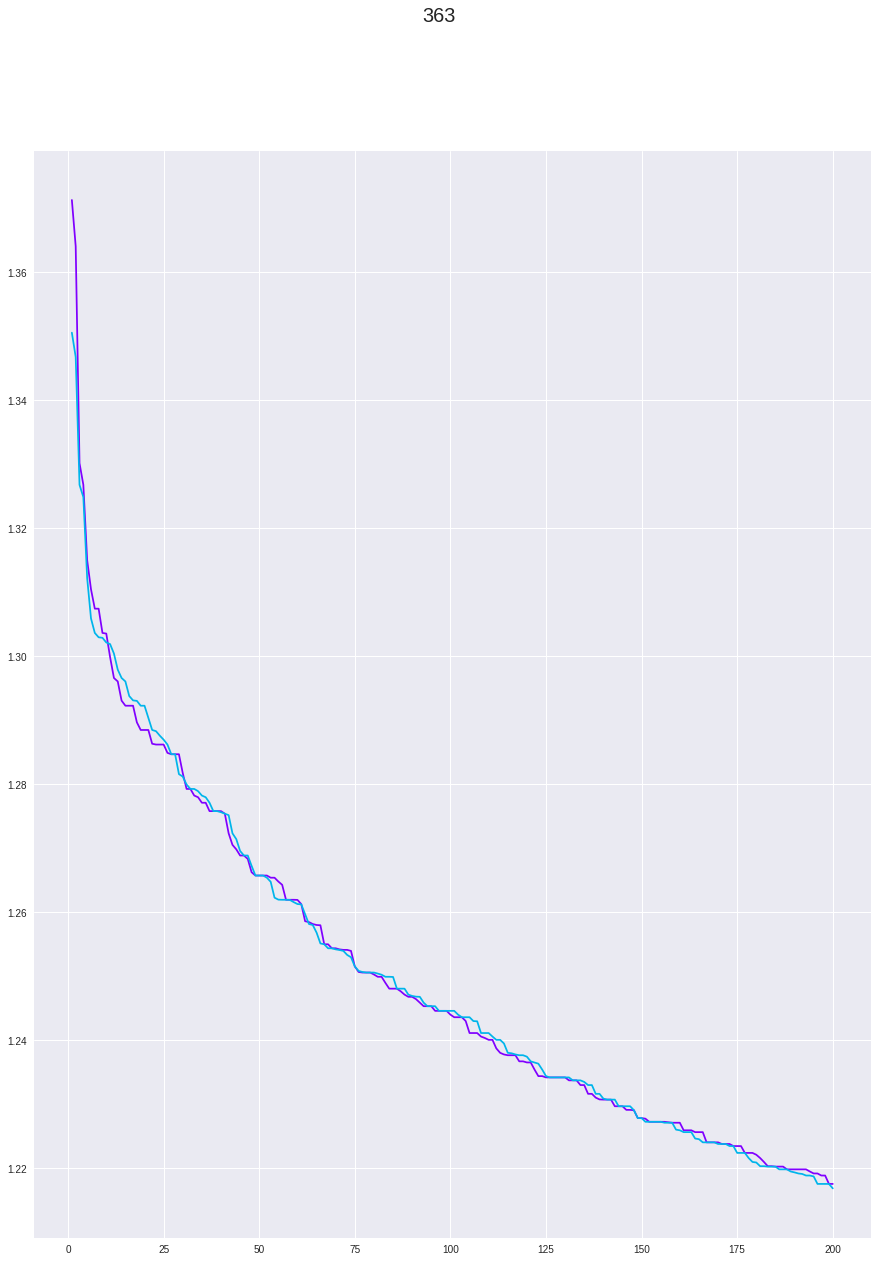

10


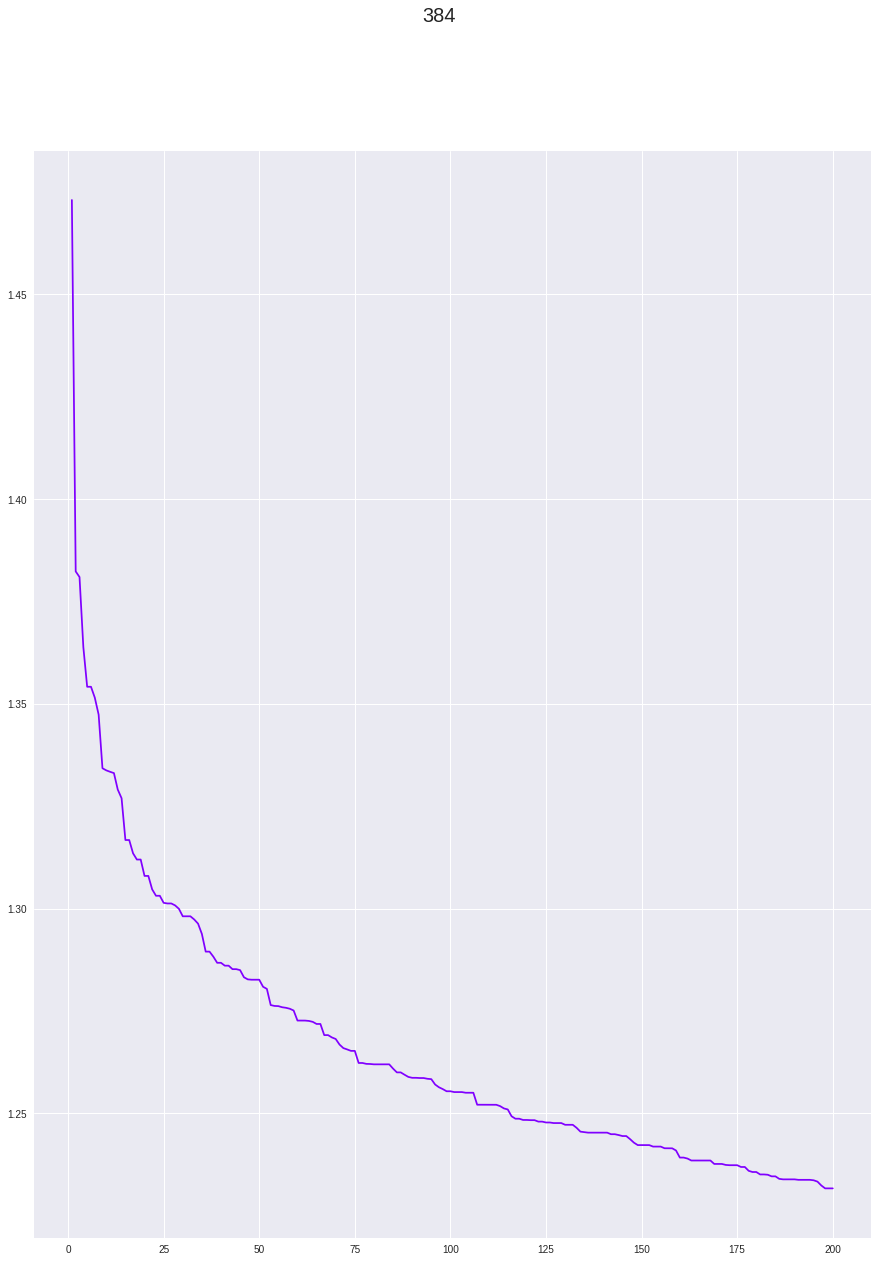

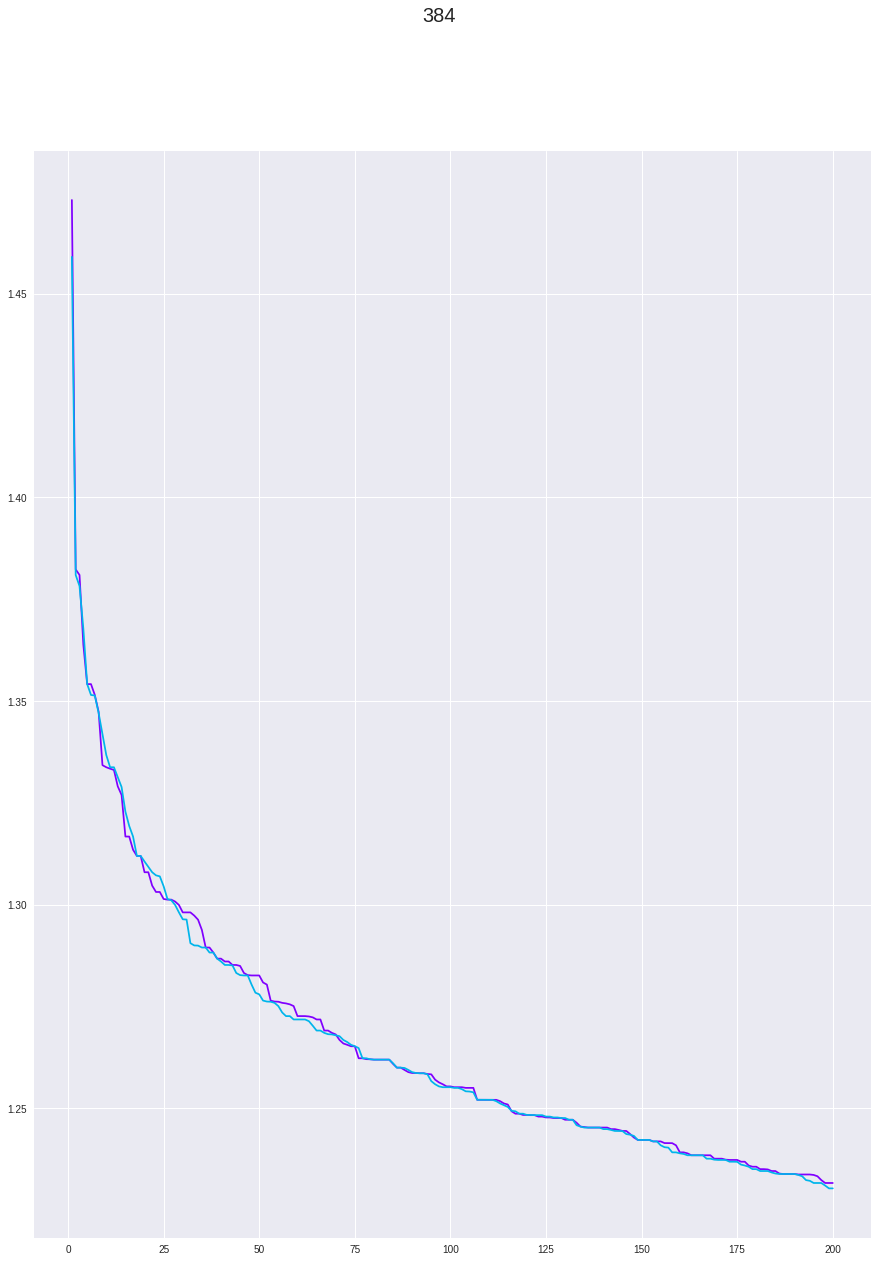

10


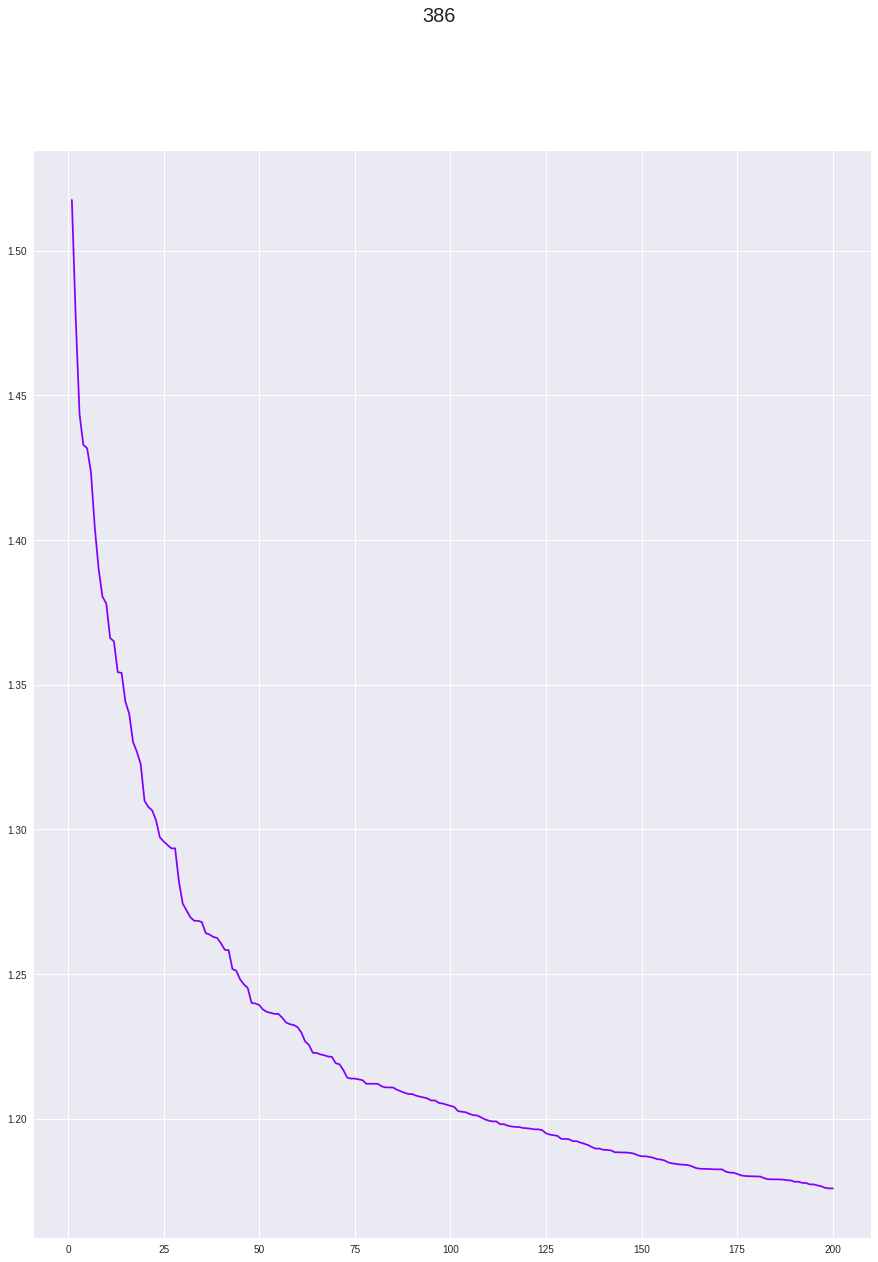

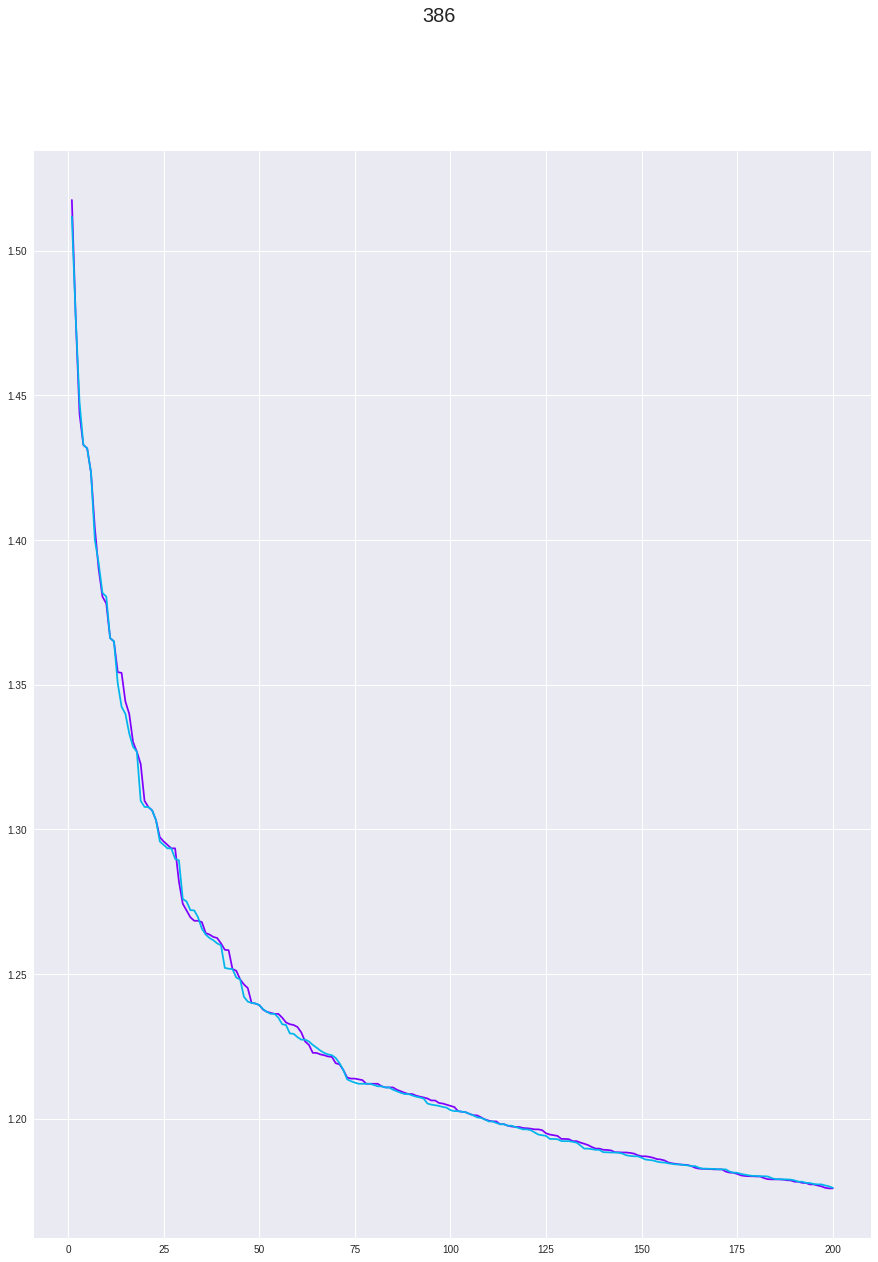

10


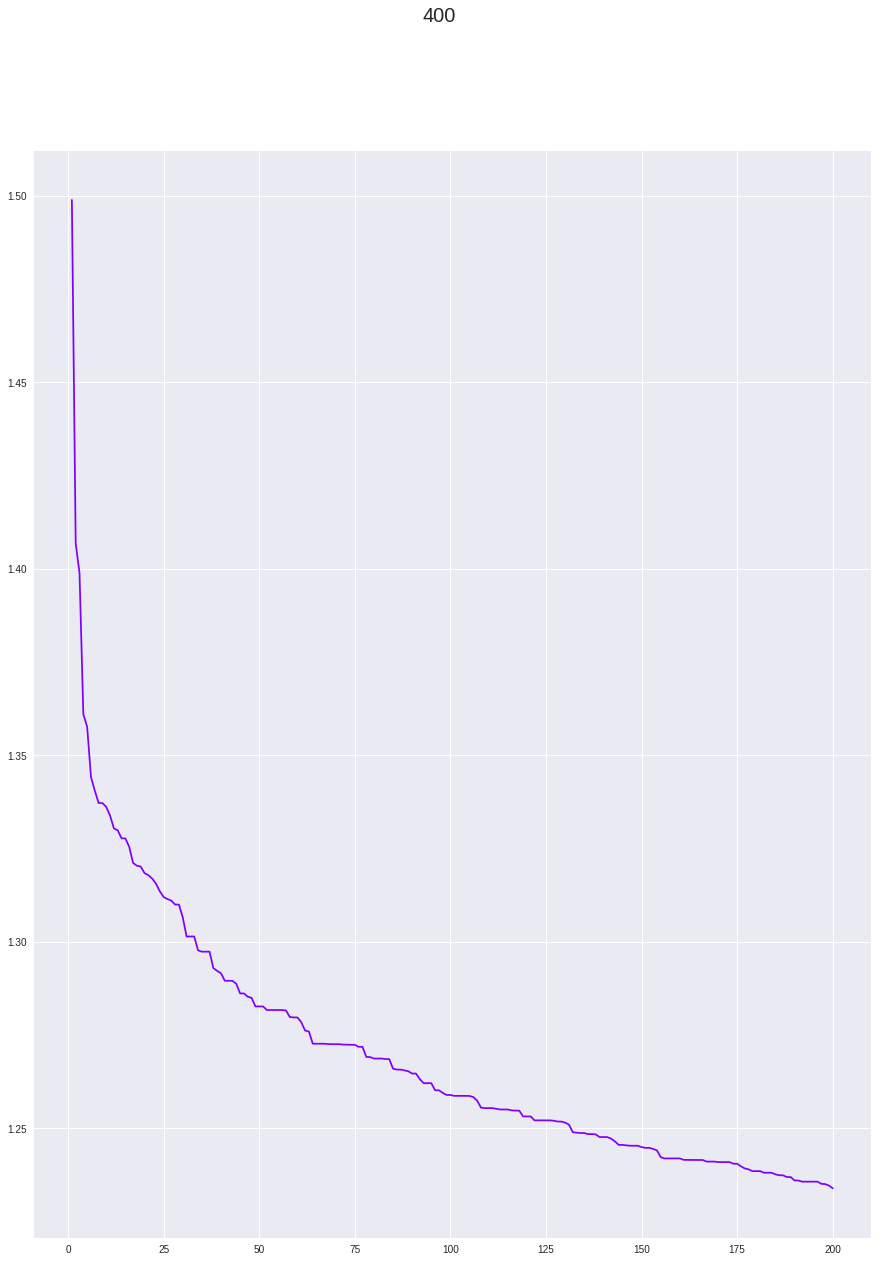

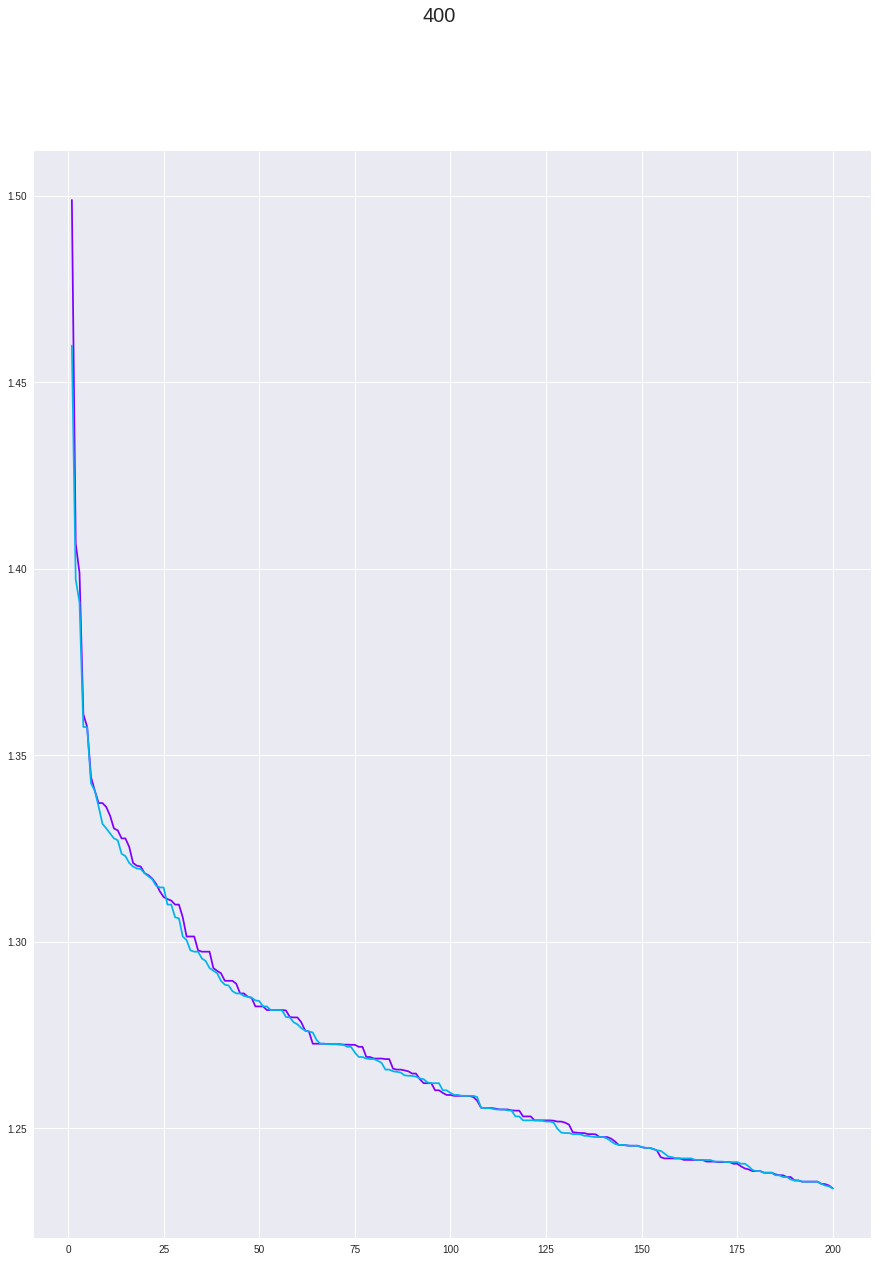

10


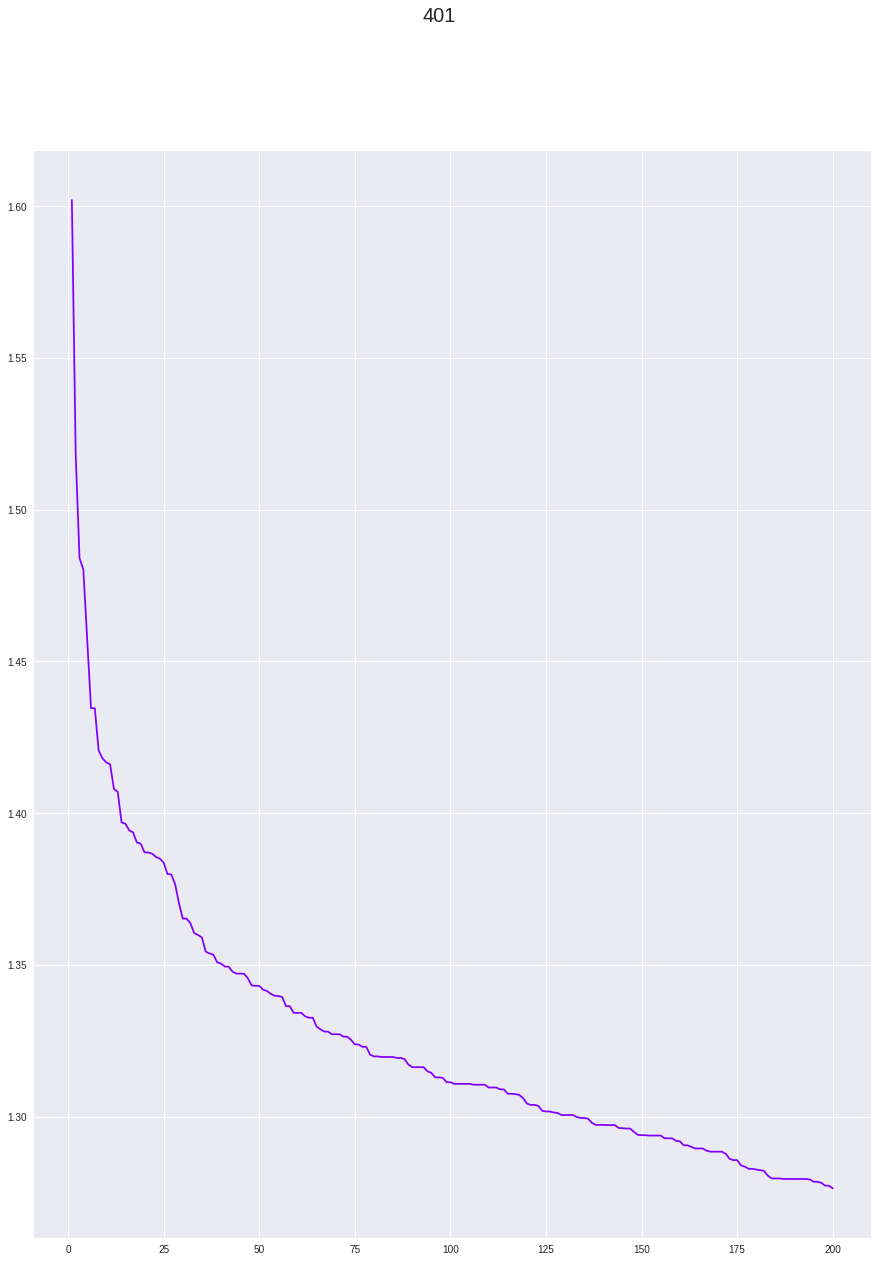

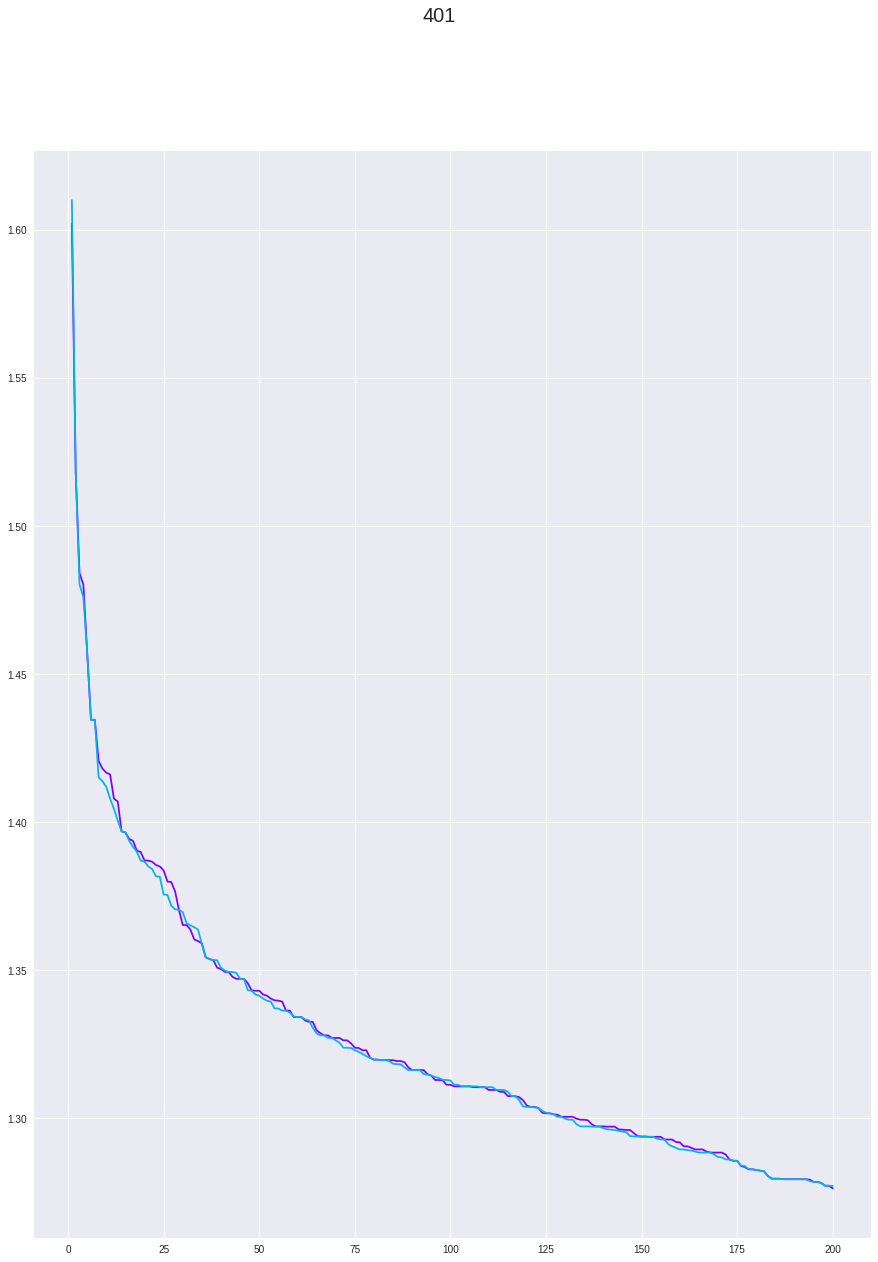

10


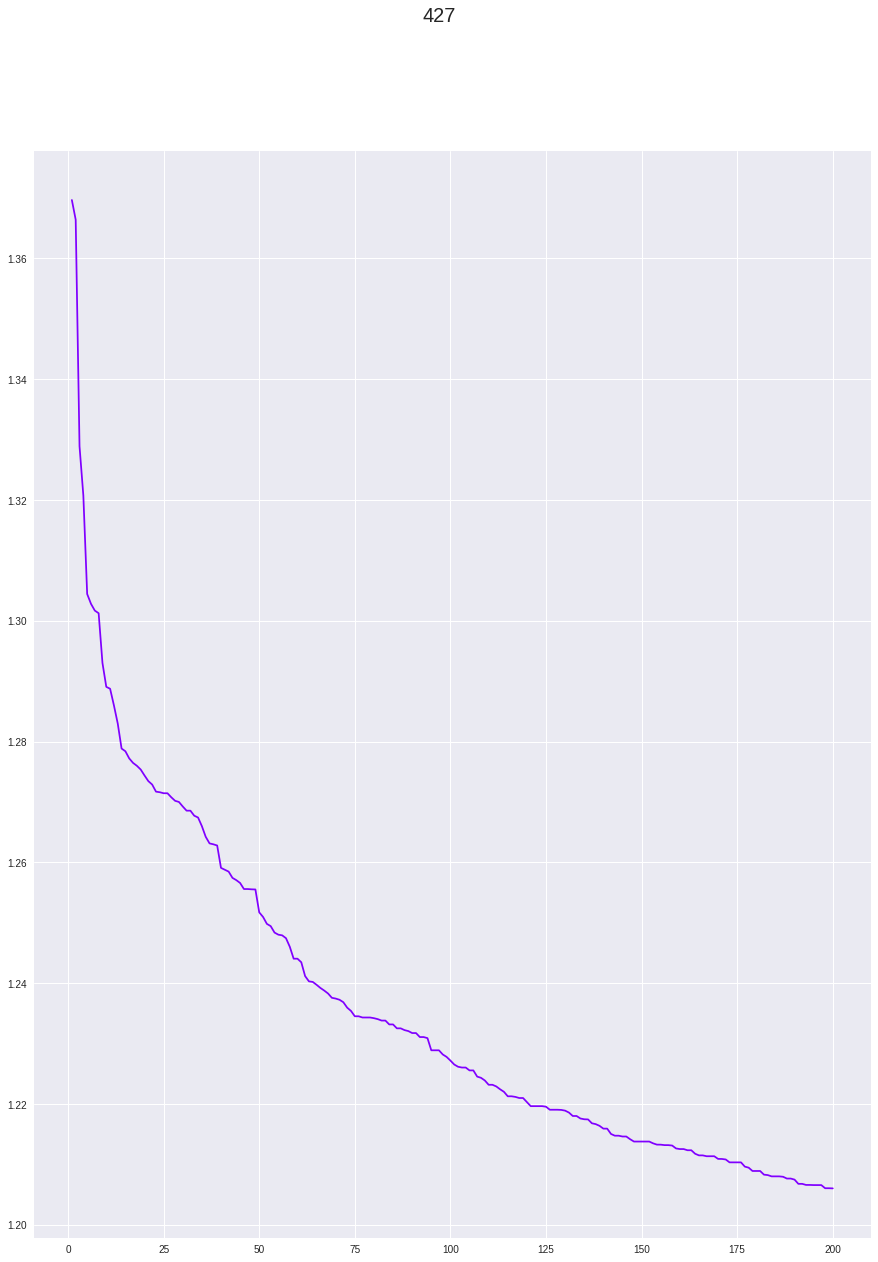

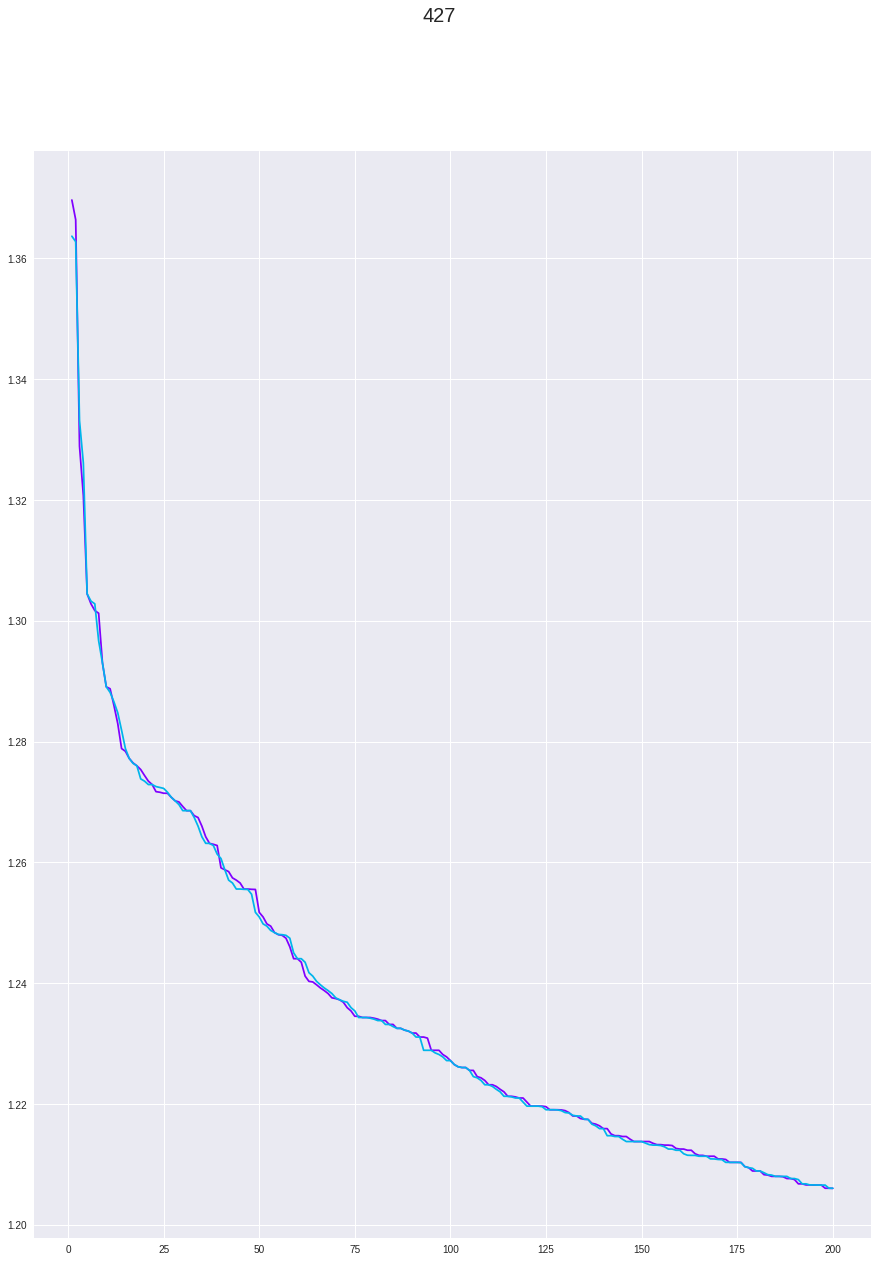

10


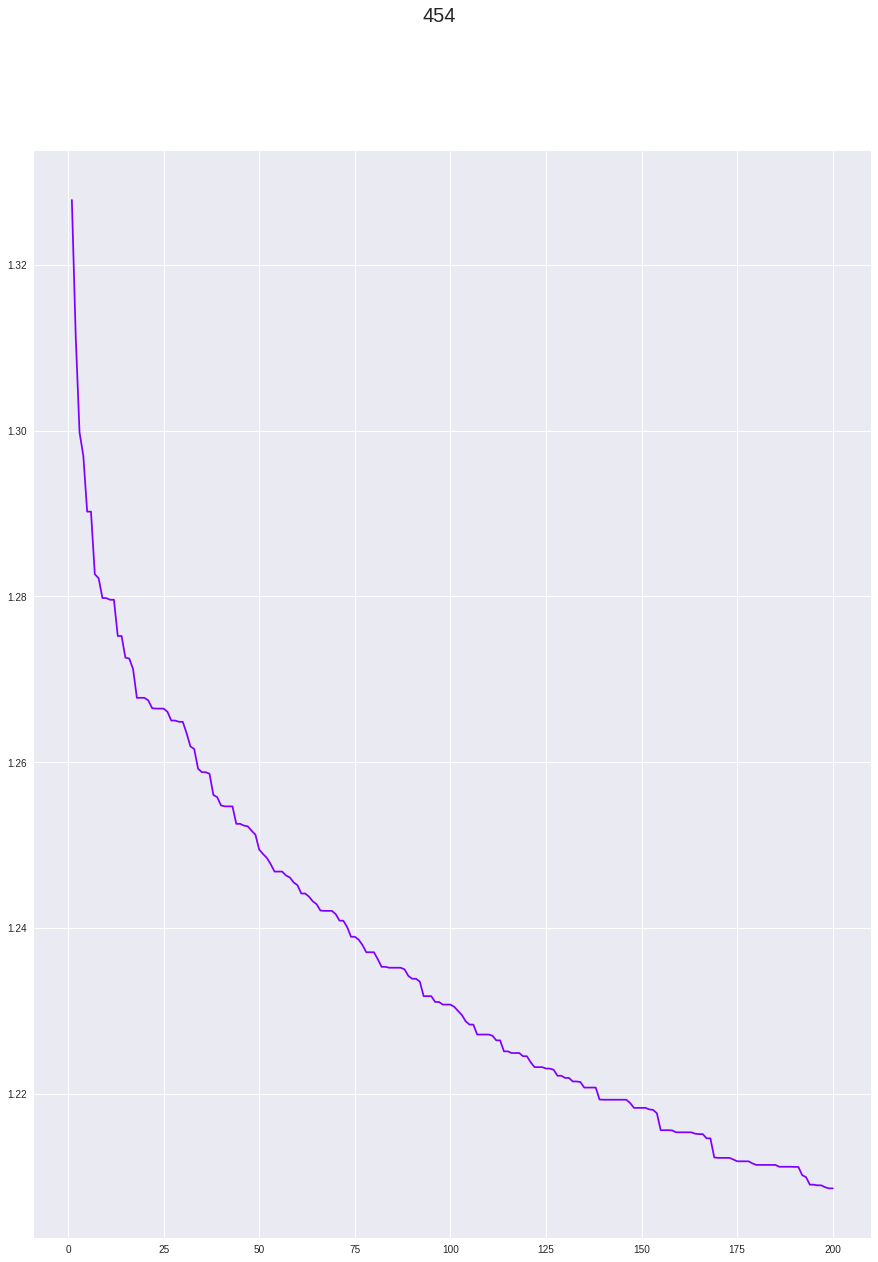

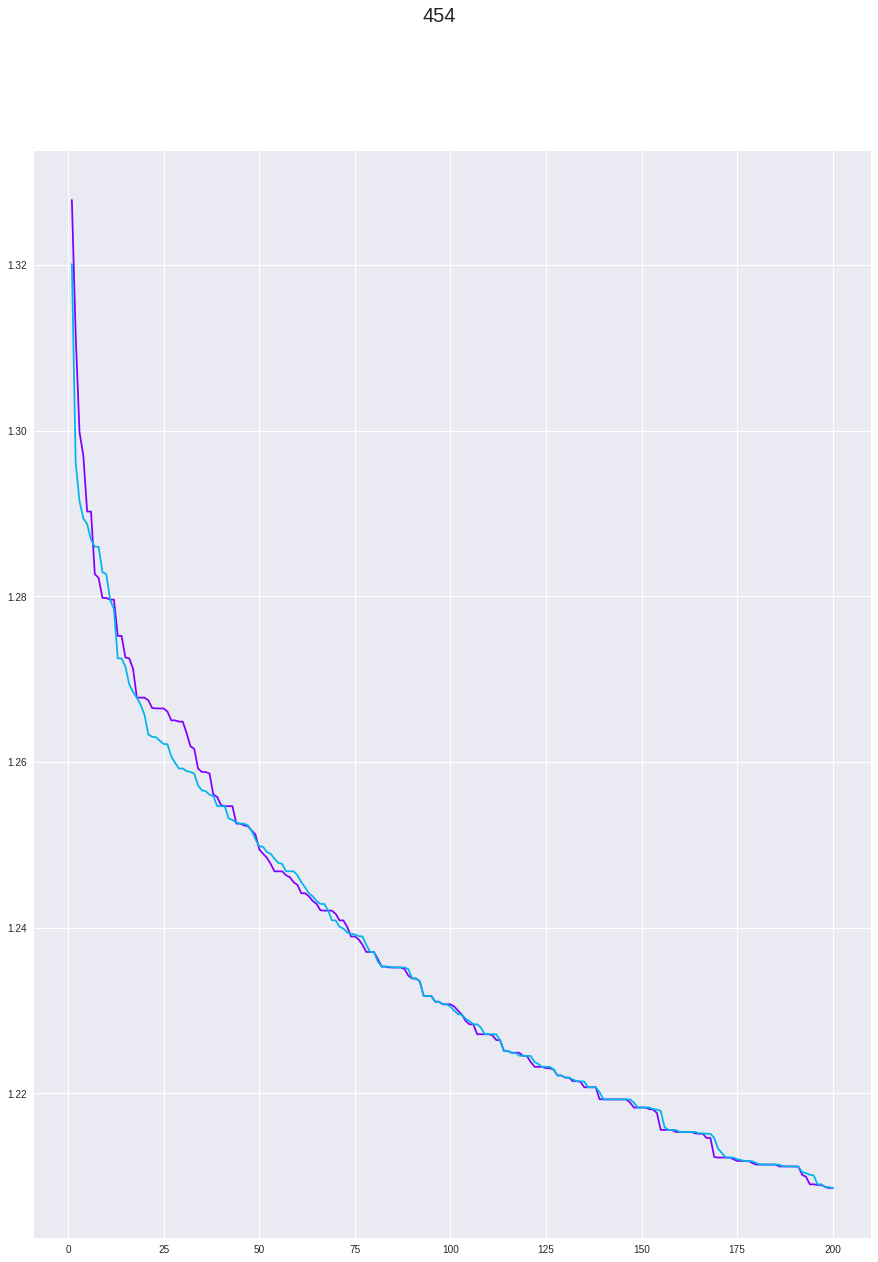

10


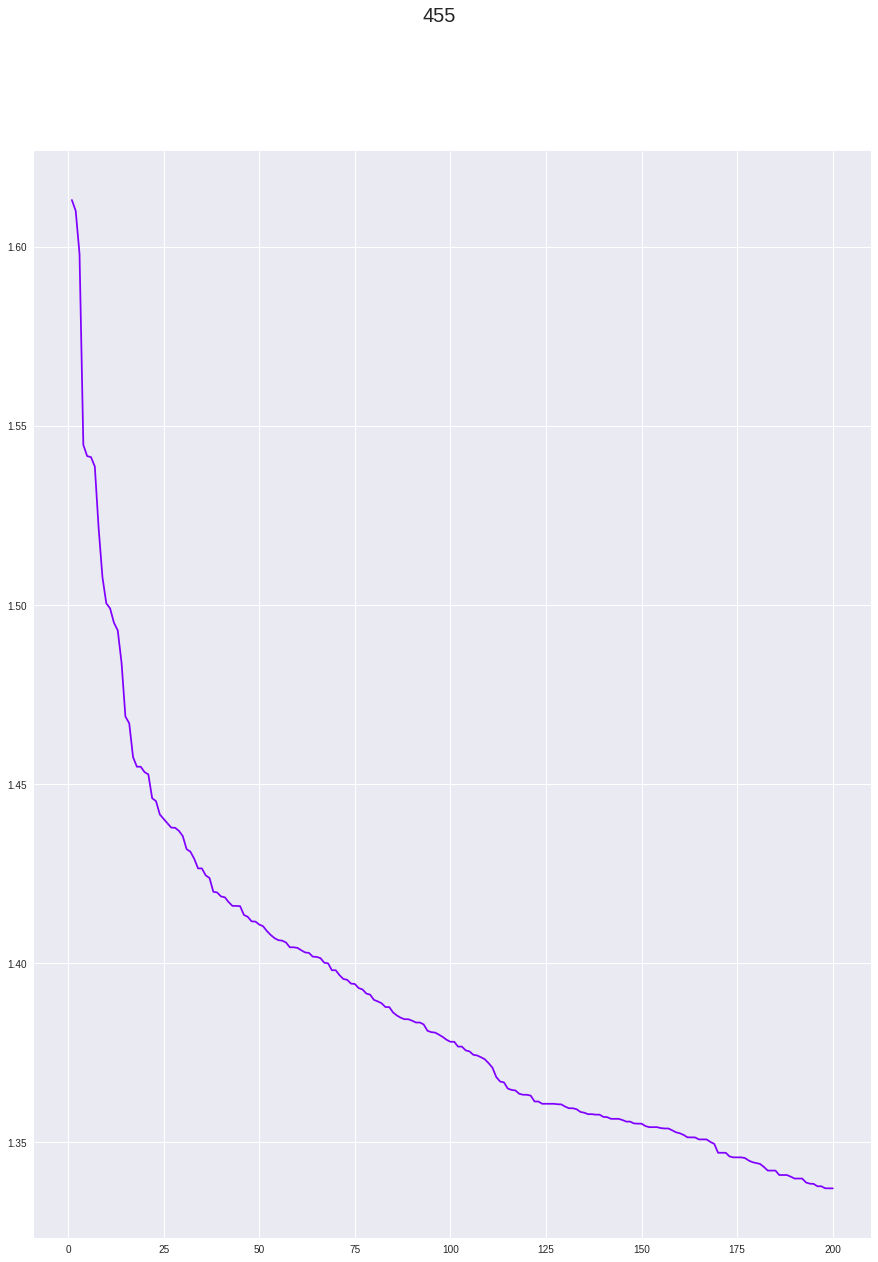

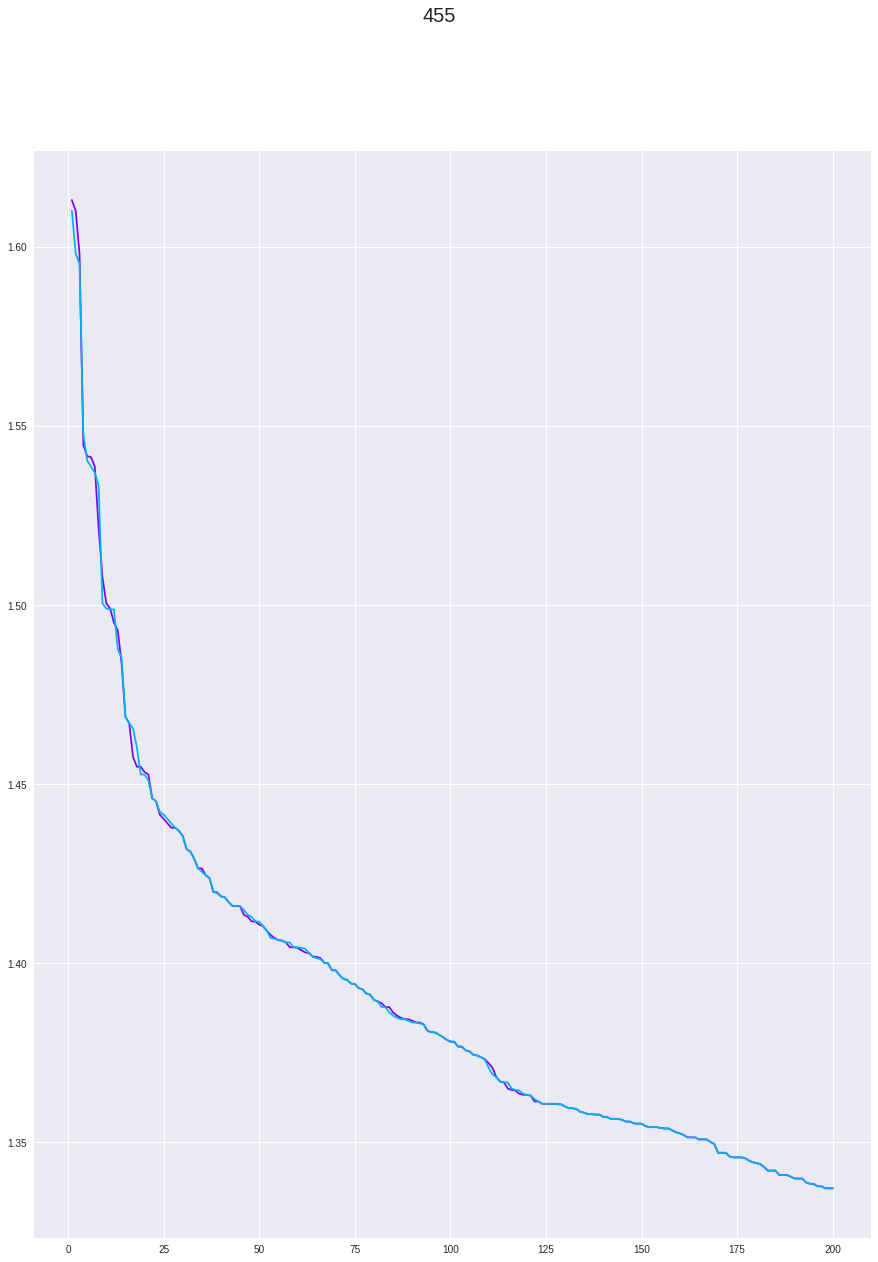

10


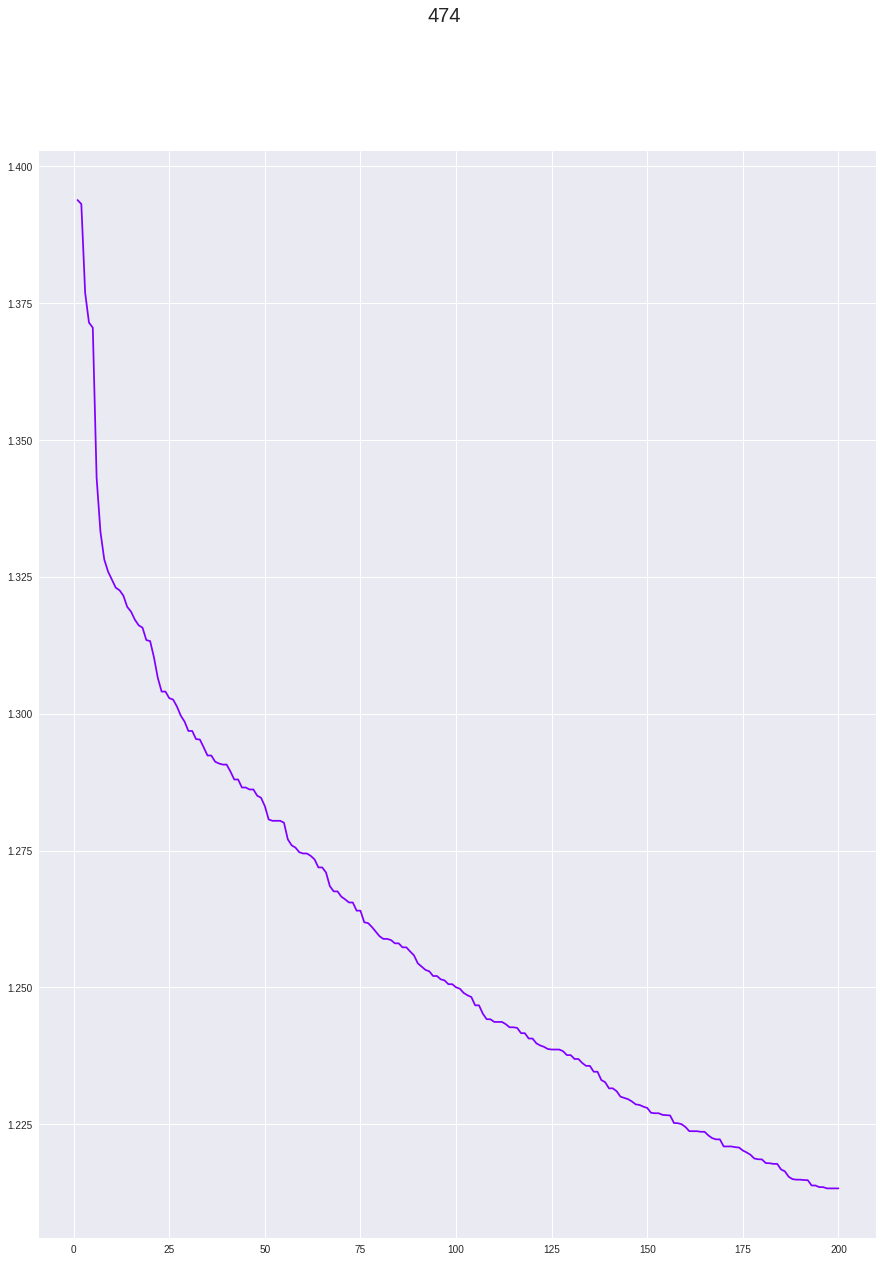

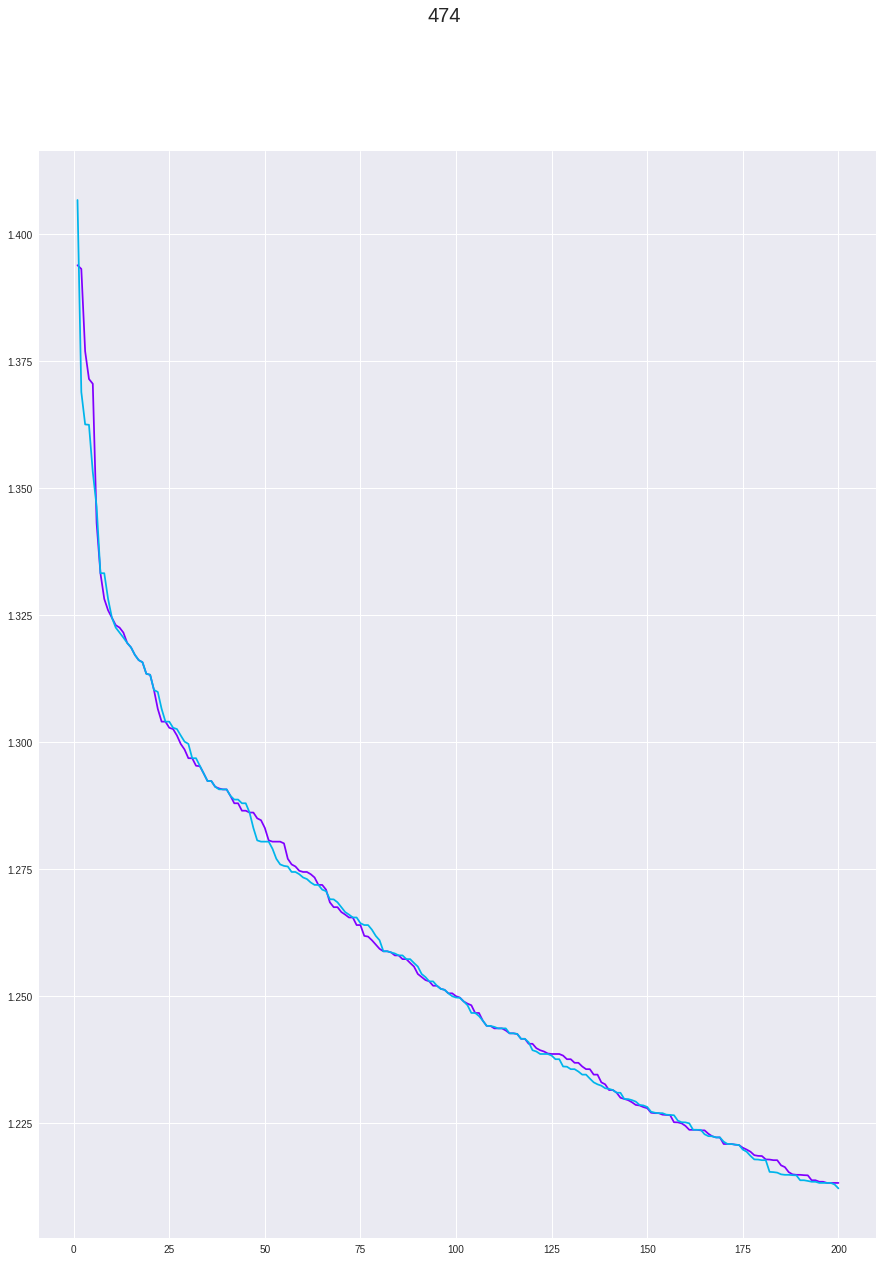

10


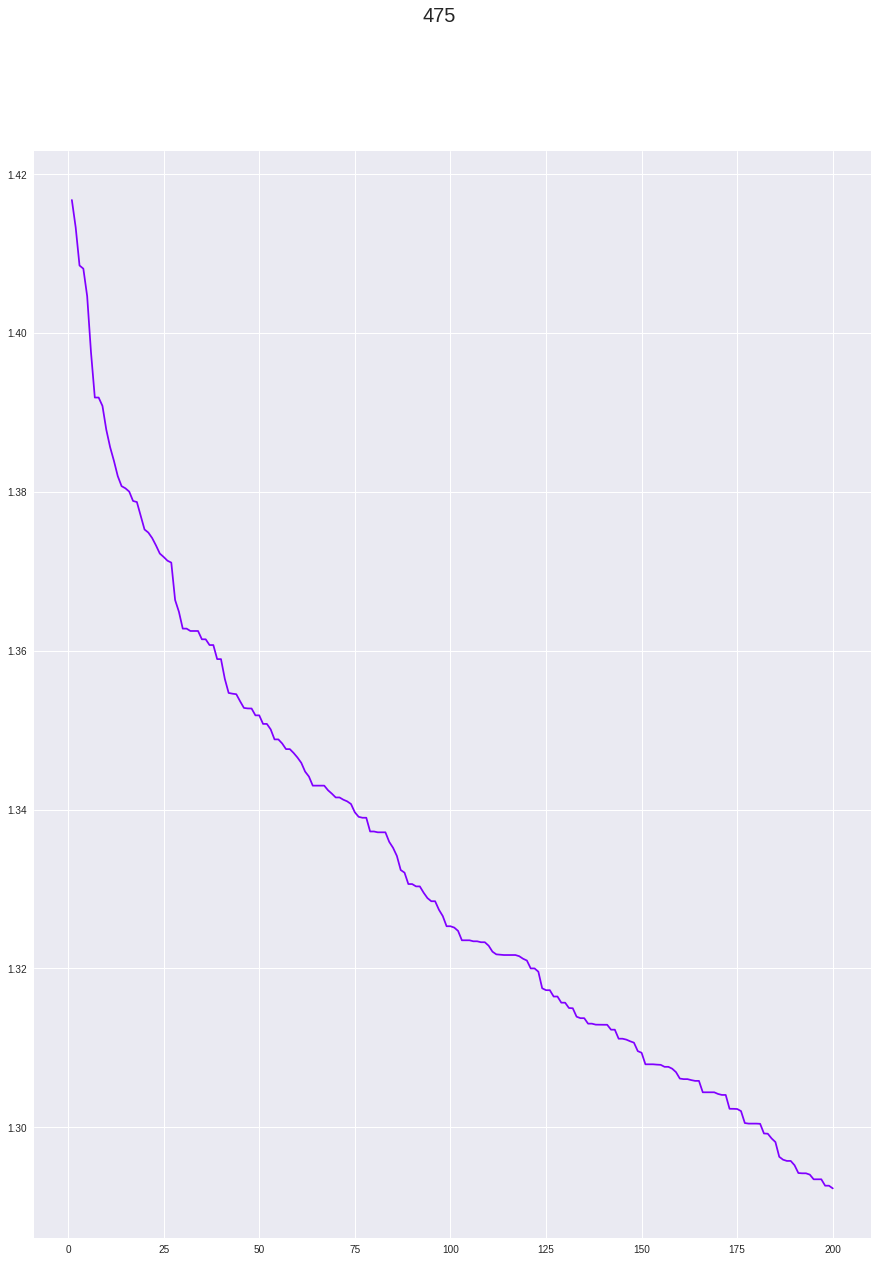

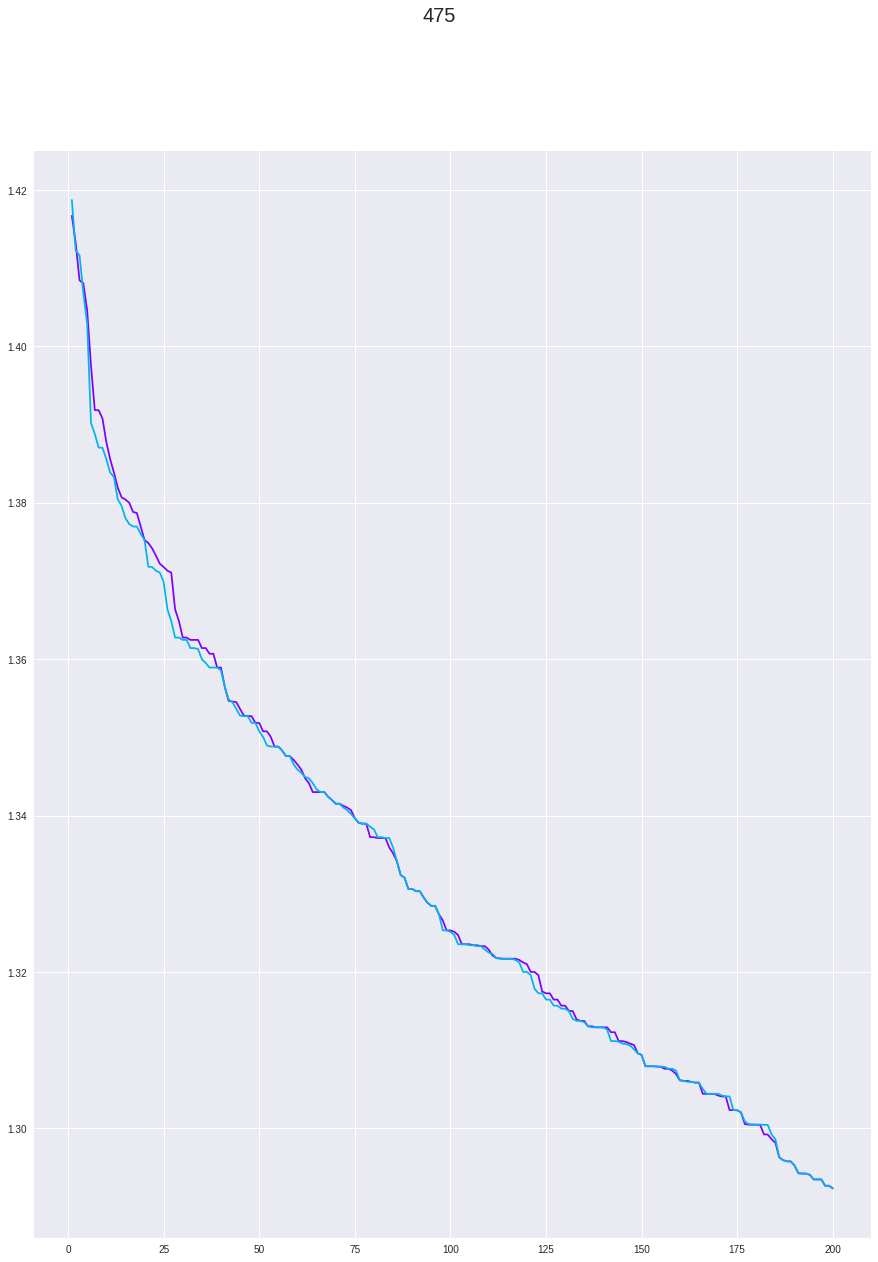

10


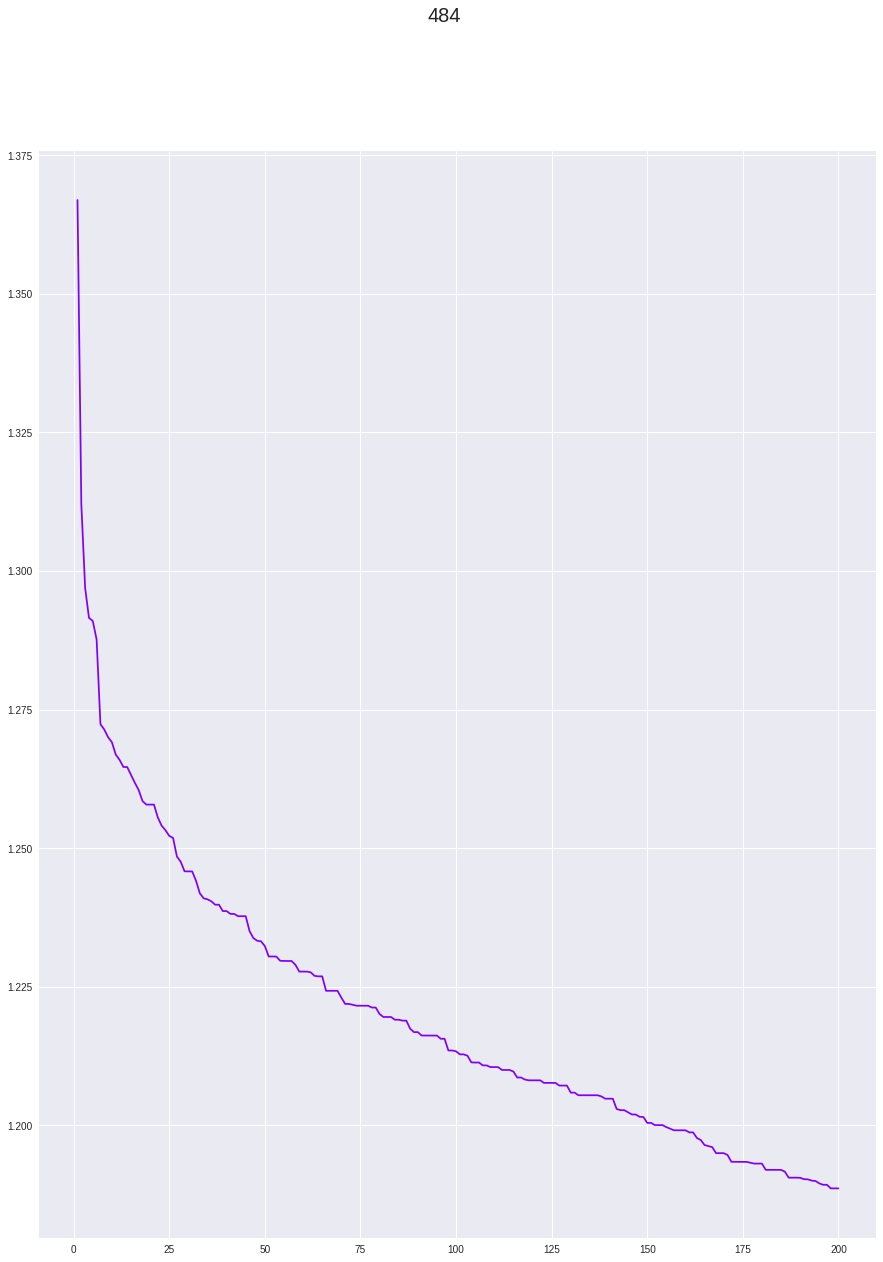

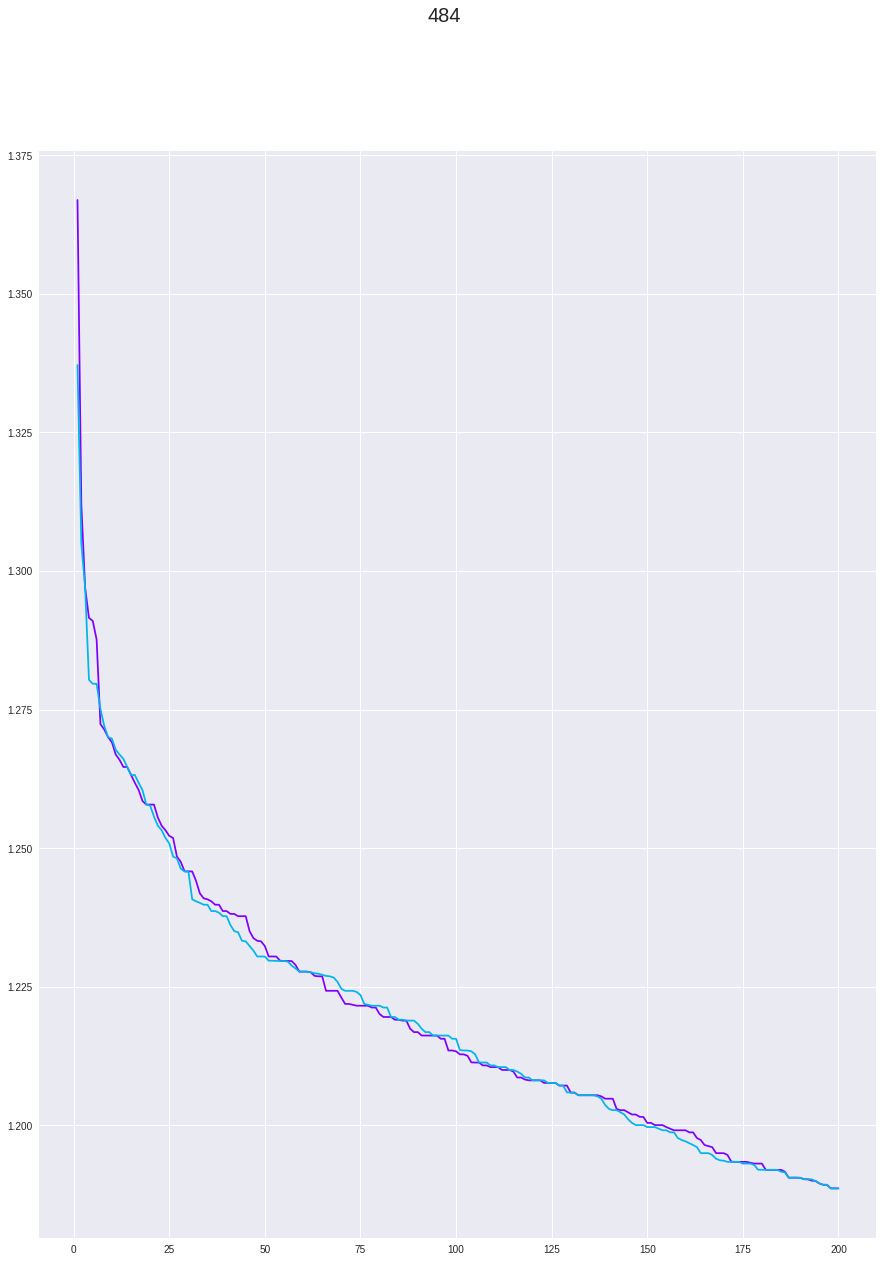

10


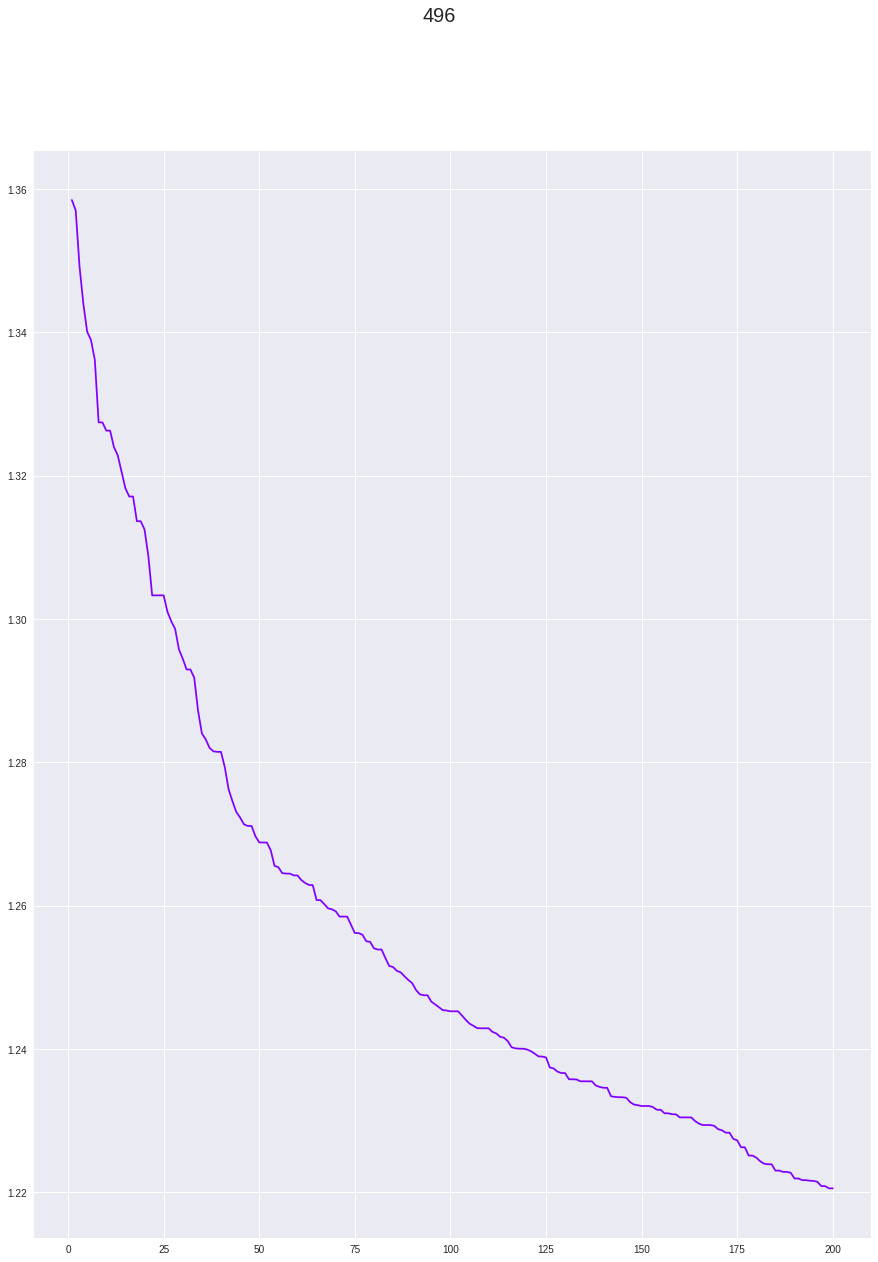

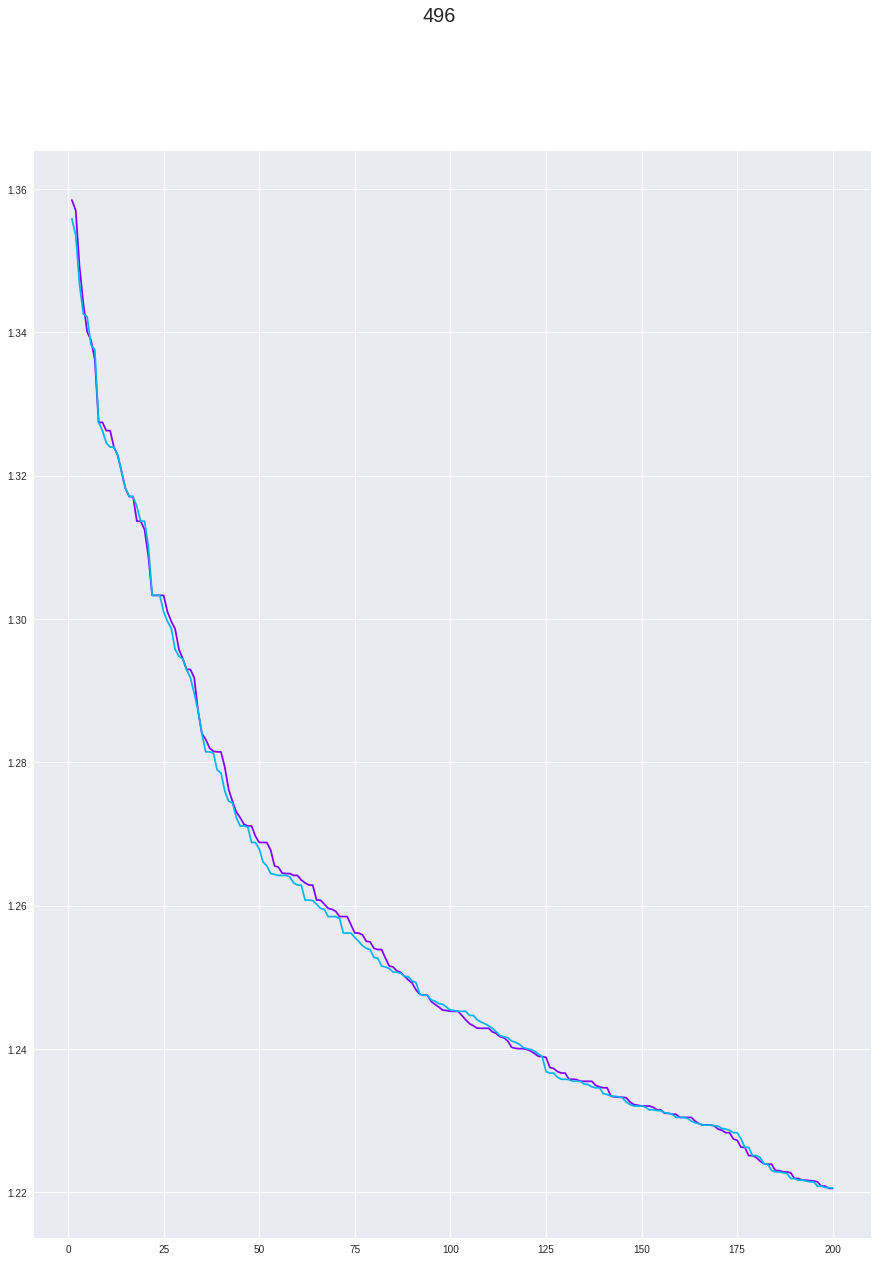

10


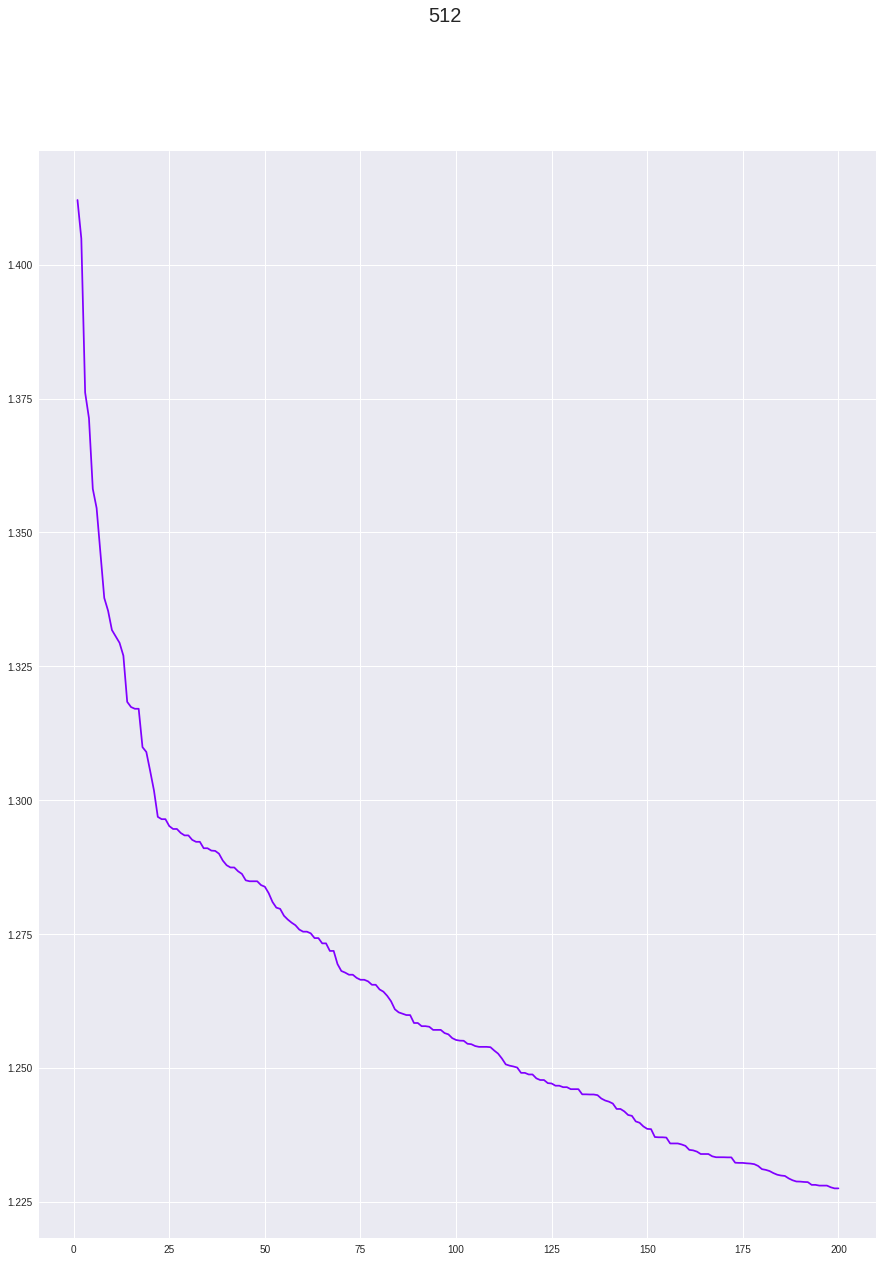

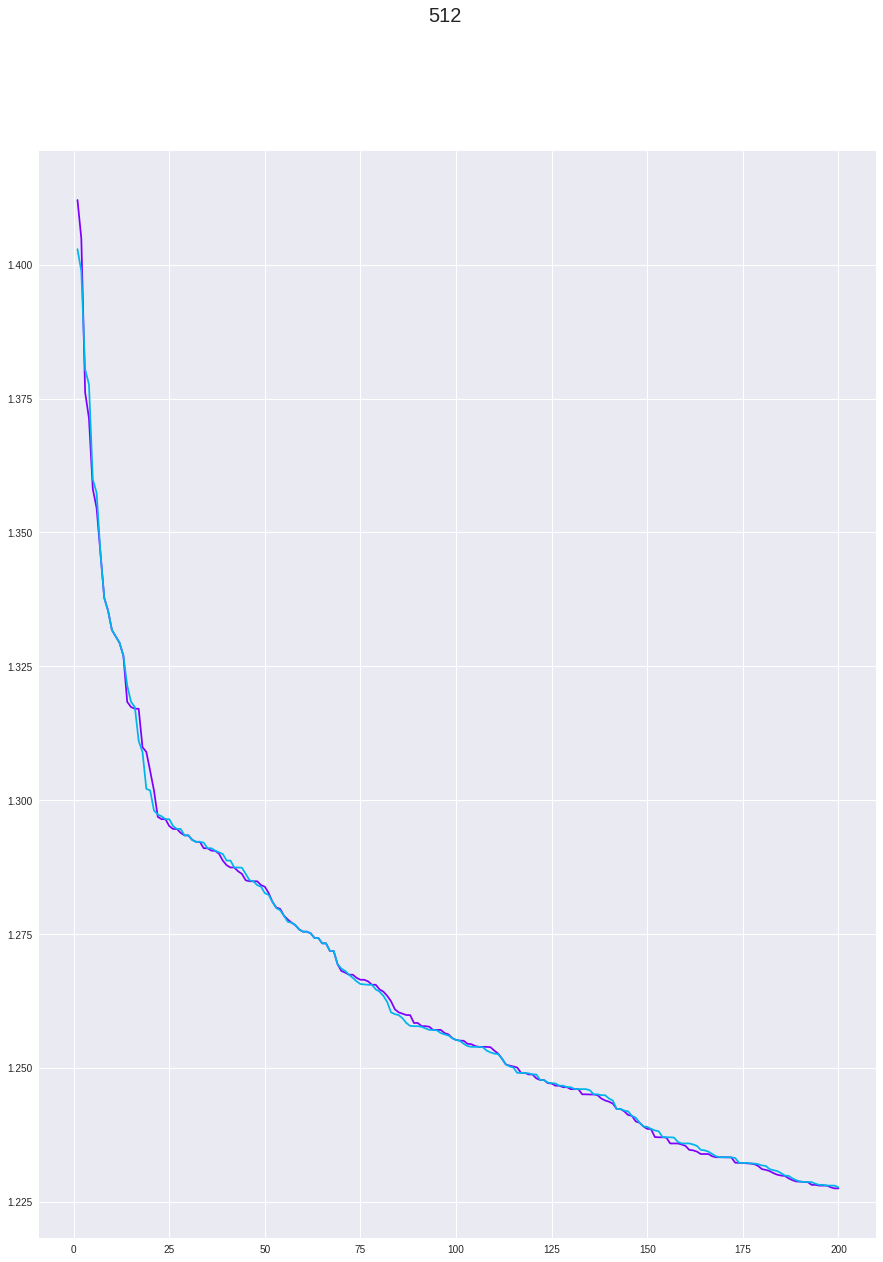

10


In [47]:
#load smoothing algorithm
pd.options.mode.chained_assignment = None  # default='warn' 
normalized_data = pd.read_csv(os.path.join(workingDir, 'output/load-smoothing-algorithm/UTconsumption.csv')) #read in csv file
del normalized_data['Unnamed: 0']
%matplotlib inline

UniqueID = normalized_data['CustomerID'].unique()
Customer_data = pd.DataFrame()
for ID in UniqueID:
    df1 = normalized_data.loc[(normalized_data['CustomerID'] == ID)]
    #add columns Charge and Discharge
    df1['Charge(kW)'] =0
    df1['Discharge(kW)'] =0

    # make empty data frame
    Total_Demand_Charges = pd.DataFrame()
    Total_Energy_Charges = pd.DataFrame()
    Total_Bill = pd.DataFrame()
    Discharge_monthly = pd.DataFrame()
    Charge_monthly = pd.DataFrame()
    dfNorm =[]
    
    for x in range(1,k): #number of smoothing iteration
        #Finding the indexes which are the highest point in "Base Usage KWh" per month.
        peak_load = df1.groupby(["month"]).apply(lambda x: x.sort_values(["Base Usage kWh"], ascending = False)) #sort values
        peak_load = peak_load.reset_index(level=1).groupby('month').first() #choose the highest value each month
        peak_load.rename(columns={'level_1':'choosen_index'},inplace=True) #look at the index 
        peak_load.reset_index(level=[0], inplace=True)

        #choose the index that will be changed
        indexes = peak_load['choosen_index'].unique()
            
        # plotting the peak demand - change for each iteration
        if x == 1 or x % ((k-1)) == 0: #change which iteration you would like to graph the norm
            # find the average normalized in the hour
            df2 = df1.groupby(df1.index // 4).mean().reset_index(drop=True)
            df2 = df2[['month','day','hour','Norm']]
            
            #sort from high to low Norm
            df2 = df2.sort_values('Norm',ascending=False).reset_index(drop=True)
            
            #graph normalized curve 
            df2time = list(range(1,201)) #choose the first 200 hours
            dfNorm.append(df2['Norm'][0:200].values)
            newNorm = np.array(dfNorm)
            colors = mpl.cm.rainbow(np.linspace(0,1,n))
            fig, ax = plt.subplots(figsize = (15,20))
            fig.suptitle(str(ID), fontsize=20)
            for color, y in zip(colors, newNorm):
                ax.plot(df2time, y, color=color)
            plt.show()    
        else:
            pass

        #Bill Calculation
        if x == 1 or x % ((k-1)) == 0:
            #make sure sum kWh stay the same after all iterations
            sum_kWh = df1['Base Usage kWh'].sum()
            #logging.debug('Total kWh Usage:{}'.format(sum_kWh)) 

            # June-September $ per kW during max On-Peak and Mid-Peak and Off-Peak each month 
            mthOPD_Summer= monthlyOnPeakMaxDemand(df1)
            mthOPD_Summer_bill = mthOPD_Summer['On-Peak Demand Charges ($)'].sum()

            mthMidD = monthlyMidPeakMaxDemand(df1)
            mthMidD_bill = mthMidD ['Mid-Peak Demand Charges ($)'].sum()

            mthOffD = monthlyOffPeakMaxDemand(df1) 
            mthOffD_bill = mthOffD ['Off-Peak Demand Charges ($)'].sum()

            #logging.debug("On: %d Mid: %d Off: %d" % (mthOPD_Summer_bill, mthMidD_bill, mthOffD_bill))

            TOU_demand_charges = mthOPD_Summer_bill + mthMidD_bill + mthOffD_bill
            #logging.debug("TOU Demand charges: {}".format(TOU_demand_charges))

            # facilities demand charge: Year-round $ per maximum kW during the entire month
            mthFacilityDemand = DemandFacilityCharge(df1)
            mthFacilityDemand_bill = mthFacilityDemand['Facility_Demand Charges ($)'].sum()
            #logging.debug("Facilities Demand charges: {}".format(mthFacilityDemand_bill))

            #total demand charge
            total_demand_charges = TOU_demand_charges + mthFacilityDemand_bill
            Total_Demand_Charges = Total_Demand_Charges.append(add_iteration_bill(total_demand_charges,x))
            #logging.debug("Demand charges: {}".format(total_demand_charges))

            #energy bill
            mthOPE_Summer = monthlyOnPeakEnergy(df1)
            mthOPE_Summer_bill = mthOPE_Summer['On-Peak Energy Charges ($)'].sum()
            mthOffE = monthlyOffPeakEnergy(df1)
            mthOffE_bill = mthOffE ['Off-Peak Energy Charges ($)'].sum()
            mthMidE = monthlyMidPeakEnergy(df1)
            mthMidE_bill = mthMidE['Mid-Peak Energy Charges ($)'].sum()

            #total energy charge
            total_energy_charges = mthOPE_Summer_bill + mthOffE_bill + mthMidE_bill
            Total_Energy_Charges= Total_Energy_Charges.append(add_iteration_bill(total_energy_charges,x))
            #logging.debug("Energy charges: {}".format(total_energy_charges))

            #total bill
            total_bill = total_demand_charges + total_energy_charges
            Total_Bill = Total_Bill.append(add_iteration_bill(total_bill,x))
            #logging.debug("total charges: {}".format(total_bill))
            
            # sum of discharge and charge by month for each iteration
            discharge = df1.groupby('month')['Discharge(kW)'].sum()
            Discharge_monthly = Discharge_monthly.append(add_iteration_bill(discharge,x)) #check discharge and charge if they are equal

            charge = df1.groupby('month')['Charge(kW)'].sum()
            Charge_monthly = Charge_monthly.append(add_iteration_bill(charge,x))
            Charge_monthly.to_csv(os.path.join(workingDir, 'output/load-smoothing-algorithm/', str(ID)+ '_charge.csv'))

        else:
            pass

        # show change in base usage kWh and normalized data
        for i in indexes:
            average_twoloadsNorm = (df1.loc[i-1,:]['Norm'] + df1.loc[i+1,:]['Norm'])/2
            deltaNorm = df1.loc[i,:]['Norm'] - average_twoloadsNorm #find the delta to the average norm data
            deltaNorm = deltaNorm/n #the load that will be added on loads surrounding peak load
            df1.loc[i,'Norm'] = average_twoloadsNorm + deltaNorm

            average_twoloadsKWH = (df1.loc[i-1,:]['Base Usage kWh'] + df1.loc[i+1,:]['Base Usage kWh'])/2
            deltaKWH = df1.loc[i,:]['Base Usage kWh'] - average_twoloadsKWH
            deltaKWH = deltaKWH / n

            df1.loc[i, 'Base Usage kWh'] = average_twoloadsKWH + deltaKWH
            df1.loc[i, 'Discharge(kW)'] = df1.loc[i, 'Discharge(kW)'] - deltaKWH * (n-1)

            #sum discharge
            for a in range(1,(n-1)//2+1):
                #smoothen the curve out to the both side data
                df1.loc[i-a,'Base Usage kWh'] = df1.loc[i-a,'Base Usage kWh'] + deltaKWH
                df1.loc[i-a,'Charge(kW)'] = df1.loc[i-a,'Charge(kW)'] + deltaKWH
                df1.loc[i+a,'Base Usage kWh'] = df1.loc[i+a,'Base Usage kWh'] + deltaKWH
                df1.loc[i+a,'Charge(kW)'] = df1.loc[i+a,'Charge(kW)'] + deltaKWH

                df1.loc[i-a,'Norm'] = df1.loc[i-a,'Norm'] + deltaNorm
                df1.loc[i+a,'Norm'] = df1.loc[i+a,'Norm'] + deltaNorm

        #print iteration
        if x% 10 == 0:
            print ('%d' %(x))
            
    #bill dataframe with demand,energy and total bill charges        
    Total_Demand_Charges.columns = ['Iteration','Total Demand Charges($)']
    Total_Energy_Charges.columns = ['Iteration','Total Energy Charges($)']
    Total_Bill.columns = ['Iteration','Total Bill($)']
    dfs = [Total_Demand_Charges,Total_Energy_Charges,Total_Bill]
    Bill_Final = reduce(lambda left,right: pd.merge(left,right,on=['Iteration'],how ='outer'), dfs)
    Bill_Final['Demand Charge Percentage'] = Bill_Final['Total Demand Charges($)']/Bill_Final['Total Bill($)'] * 100
    Bill_Final.to_csv(os.path.join(workingDir, 'output/load-smoothing-algorithm/', str(ID)+ '_bill.csv'))
    
    #output last iteration of 15 min data to csv file
    df1.to_csv(os.path.join(workingDir, 'output/load-smoothing-algorithm/', str(ID)+ '_last_iteration.csv'))

In [45]:
mthMidD

,level_1,day,hour,minute,day_of_year,year,Mid-Peak Energy (kWh),CustomerID,Norm,Rate Periods,Season,Hour,Energy_charges($/kWh),Charge(kW),Discharge(kW),Mid-Peak Demand (kW),Mid-Peak Demand Charges ($)
month,,,,,,,,,,,,,,,,,
6,578375,16,10,45,168,2012,98.5803,512,1.267208,2.0,Summer,Mid,0.08035,0,0.0,394.3212,1553.63
7,580996,13,18,0,195,2012,98.5803,512,1.221623,2.0,Summer,Mid,0.08035,0,0.0,394.3212,1553.63
8,584039,14,10,45,227,2012,100.5585,512,1.226920,2.0,Summer,Mid,0.08035,0,0.0,402.2340,1584.80
9,587014,14,10,30,258,2012,94.2942,512,1.217269,2.0,Summer,Mid,0.08035,0,0.0,377.1768,1486.08
1,564263,21,9,45,21,2012,137.1554,512,2.244312,5.0,Winter,Mid,0.07538,0,0.0,548.6216,0.00
2,566208,10,16,0,41,2012,85.0626,512,1.358339,5.0,Winter,Mid,0.07538,0,0.0,340.2504,0.00
3,570913,30,17,15,90,2012,88.0299,512,1.375583,5.0,Winter,Mid,0.07538,0,0.0,352.1196,0.00
4,573023,21,16,45,112,2012,99.5694,512,1.448048,5.0,Winter,Mid,0.07538,0,0.0,398.2776,0.00
5,575891,21,13,45,142,2012,93.9645,512,1.273491,5.0,Winter,Mid,0.07538,0,0.0,375.8580,0.00
